# W261 - Flight Delay Prediction

## Data Engineering and Model Development

### Team 10:
  * YuLing Chen
  * Mitchel Li
  * Lesley Matheson
  * Ernesto Oropeza

### Link to EDA Notebook

The flow begins with the EDA notebook (Sections 1 and 2). The EDA was separated so that the notebook does not get too long and complex.

Link: https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4061768275142291/command/4061768275142292

The results from the initial EDA and further consideration of the domain led to an approach for transforming existing table features to accommodate joining the Weather Table to the Airline Flight Table and engineering features from the Airline Flight Table data. The results of this preprocessing and feature engineering are presented below. Subsequent sections discuss the model development, model pipeline, the impact of the new features, and a summary of results.

### 3. Preprocessing and Feature Engineering

In [0]:
%pip install tzwhere

Python interpreter will be restarted.
Collecting tzwhere
 Downloading tzwhere-3.0.3.tar.gz (23.7 MB)
Collecting shapely
 Downloading Shapely-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (1.0 MB)
Building wheels for collected packages: tzwhere
 Building wheel for tzwhere (setup.py): started
 Building wheel for tzwhere (setup.py): finished with status 'done'
 Created wheel for tzwhere: filename=tzwhere-3.0.3-py3-none-any.whl size=23742583 sha256=82be48c49918868b54b4a68093261022d96c0290600d776b2ad0303d19be90f3
 Stored in directory: /root/.cache/pip/wheels/a4/27/39/8c57d78844da3630f08a30bfe9da5eac9a290e0a7edcb98218
Successfully built tzwhere
Installing collected packages: shapely, tzwhere
Successfully installed shapely-1.7.1 tzwhere-3.0.3
Python interpreter will be restarted.

In [0]:
# Importing libraries for preprocessing, feature engineering, model development and metrics
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql import Window
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import *

from pyspark.ml import Pipeline

from tzwhere import tzwhere
import pandas as pd
import numpy as np
import datetime as dt
import pytz
import urllib

from datetime import datetime, timedelta
from datetime import timedelta
from dateutil import parser
import math as m
import random
from pyspark.sql import Row
from pyspark.sql.functions import when

import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

sqlContext = SQLContext(sc)

In [0]:
# Loading the Airline Flight Table
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/201*.parquet")

##### 3.1 Date Range Functionality and Removing Cancelled Flights

Preprocessing feature engineering steps required the ability to filter tables based on date ranges and create unified timestamps.  The following functions were developed to enable feature prepocessing.  These functions remove flights from the Airline Flight Table that were cancelled.

In [0]:
# This cell is for filtering cancelled flights and selecting range of dates

date1= None #dt.datetime(2019,1,1) # None for all data and (year,month,day) format for range
date2 = None #dt.datetime(2015,1,2)

# Function to transform to dateime format 
def justdate(y,m,d):
  return dt.datetime(y,m,d,0,0)

udf_justdate = f.udf(justdate,DateType())

# Checking for bottom and top date limits
if (date1 == None and date2 == None):
  df_select = airlines.filter((f.col("CANCELLED") == 0)) \
                      .withColumn('DATE',udf_justdate("YEAR","MONTH","DAY_OF_MONTH"))                     
  
  datei, datef = df_select.select(min("DATE"), max("DATE")).first()
  date1 = dt.datetime(datei.year,datei.month,datei.day)
  date2 = dt.datetime(datef.year,datef.month,datef.day)
  df_select = df_select.drop('DATE')
  
elif (date1 == None and date2 != None):
  df_select = airlines.filter((f.col("CANCELLED") == 0))
  df_select = df_select.withColumn('DATE',udf_justdate("YEAR","MONTH","DAY_OF_MONTH")) \
                       .where(f.col("DATE") <= date2)
  
  datei = df_select.select(min("DATE")).first()
  date1 = dt.datetime(datei.year,datei.month,datei.day)
  df_select = df_select.drop('DATE')
  
  
elif (date1 != None and date2 == None):
  df_select = airlines.filter((f.col("CANCELLED") == 0)) \
                      .withColumn('DATE',udf_justdate("YEAR","MONTH","DAY_OF_MONTH")) \
                      .where(f.col("DATE") >= date1)

  datef = df_select.select(max("DATE")).first()
  date2 = dt.datetime(datef.year,datef.month,datef.day)
  df_select = df_select.drop('DATE')
  

elif (date1 != None and date2 != None):
  if (date1 > date2):
    df_select = airlines.filter((f.col("CANCELLED") == 0)) \
                        .withColumn('DATE',udf_justdate("YEAR","MONTH","DAY_OF_MONTH"))
    
    datei, datef = df_select.select(min("DATE"), max("DATE")).first()
    date1 = dt.datetime(datei.year,datei.month,datei.day)
    date2 = dt.datetime(datef.year,datef.month,datef.day)
    df_select = df_select.drop('DATE')

  else: 
    df_select = airlines.filter((f.col("CANCELLED") == 0)) \
                        .withColumn('DATE',udf_justdate("YEAR","MONTH","DAY_OF_MONTH")) \
                        .where(f.col("DATE").between(date1,date2)) \
                        .drop('DATE')

In [0]:
#Drop unused columns as explained in the Introduction and EDA Notebook
df_select = df_select.drop("ORIGIN_AIRPORT_SEQ_ID","ORIGIN_CITY_NAME","ORIGIN_STATE_ABR","ORIGIN_STATE_FIPS","ORIGIN_STATE_NM","ORIGIN_WAC","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","ARR_DELAY_GROUP","CANCELLED","CANCELLATION_CODE","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","FLIGHTS","DISTANCE","DISTANCE_GROUP","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY",                       "LATE_AIRCRAFT_DELAY","FIRST_DEP_TIME","TOTAL_ADD_GTIME","LONGEST_ADD_GTIME","DIV_AIRPORT_LANDINGS","DIV_REACHED_DEST","DIV_ACTUAL_ELAPSED_TIME","DIV_ARR_DELAY","DIV_DISTANCE","DIV1_AIRPORT","DIV1_AIRPORT_ID","DIV1_AIRPORT_SEQ_ID","DIV1_WHEELS_ON","DIV1_TOTAL_GTIME","DIV1_LONGEST_GTIME","DIV1_WHEELS_OFF","DIV1_TAIL_NUM","DIV2_AIRPORT","DIV2_AIRPORT_ID","DIV2_AIRPORT_SEQ_ID","DIV2_WHEELS_ON","DIV2_TOTAL_GTIME","DIV2_LONGEST_GTIME","DIV2_WHEELS_OFF","DIV2_TAIL_NUM","DIV3_AIRPORT","DIV3_AIRPORT_ID","DIV3_AIRPORT_SEQ_ID","DIV3_WHEELS_ON","DIV3_TOTAL_GTIME","DIV3_LONGEST_GTIME","DIV3_WHEELS_OFF","DIV3_TAIL_NUM","DIV4_AIRPORT","DIV4_AIRPORT_ID","DIV4_AIRPORT_SEQ_ID","DIV4_WHEELS_ON","DIV4_TOTAL_GTIME","DIV4_LONGEST_GTIME","DIV4_WHEELS_OFF","DIV4_TAIL_NUM","DIV5_AIRPORT","DIV5_AIRPORT_ID","DIV5_AIRPORT_SEQ_ID","DIV5_WHEELS_ON","DIV5_TOTAL_GTIME","DIV5_LONGEST_GTIME","DIV5_WHEELS_OFF","DIV5_TAIL_NUM")

##### 3.2 Filter Out Flights With Nulls in Flight Times 

Several features were deemed critical to usability in the model pipeline and prediction.  These features included departures and arrival times both scheduled and actual as well as flight date.  Without values in these columns, the asssumption was that the data is not useful, so the entire flight was dropped from the Airline Flight Table.

In [0]:
# Drop rows missing critical flight time and date information, including missing departure and arrival times
df_select = df_select.filter(df_select.DEP_TIME.isNotNull()) \
                     .filter(df_select.ARR_TIME.isNotNull()) \
                     .filter(df_select.FL_DATE.isNotNull()) \
                     .filter(df_select.CRS_DEP_TIME.isNotNull()) \
                     .filter(df_select.CRS_ARR_TIME.isNotNull())

##### 3.3 Creating Time Bins 

The creation of a feature that transformed the flight time into a standardized bin was used to enable the two main tables to be joined and weather data associated with a particular flight.  These time bins were created ultimately in 30 minute intervals.  These time bins with their standardized format and time enabled the interpolation of the weather data into times that could be associated with flight times easily.

In [0]:
# Creating a user defined function to translate a flight time to its nearest 30 minute increment
def f_dtran(yy,mm,dd,hora):
  """
  yy: year column
  mm: Month column
  dd: day of month column
  hora: time in integer format 'hmm'
  """
    
  h1 = hora/float(100)
  h = int(h1)
  m = int((h1-float(int(h1)))*100)
  
  if (h > 23):
    h = 0
    
  mbins = np.array([j for j in range(0,60,30)])
  m = mbins[mbins <= m][-1]
  
  tiempo = dt.datetime(yy,mm,dd,h,m)
  tiempo = tiempo - timedelta(hours = 2)
  return tiempo.strftime("%m/%d/%Y, %H:%M:%S")

udf_f_dtran = f.udf(f_dtran, StringType())

In [0]:
# Adding the new time bin to the Airline Flight Table
df_select = df_select.withColumn("DATEBIN30", udf_f_dtran("YEAR","MONTH","DAY_OF_MONTH","CRS_DEP_TIME"))

#####3.4 Creating Airport Coordinates and Time Zone Tables

As mentioned in the Introduction and EDA Notebook, the addition of several helper tables are employed. The first table enables the creation of a universal timestamp considering time zone.  A table was built that associates all airports with a timezone used by the PySpark Datetime libraries. The airport timezones were obtained from "https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap". However, this dataset does not contain all the airports. The library TZWHERE (https://github.com/pegler/pytzwhere) that take the coordinates as an input to get the official time zonethat is use for the transformation local to UTC later in the pipeline. Using these helper tables the local time employed by the airport table can be transformed to UTC and Epoch time used for the join with the Weather Table and for feature engineering. The second table associates all airports with a latitude and longitude (airport_coordinates).

In [0]:
# Loading the preprocessed file for airport coordinates and filtering for the last listed coordinates
airports_xy = spark.read.option("header", "true").csv("dbfs:/FileStore/shared_uploads/ernesto.oropeza@ischool.berkeley.edu/airport_coordinates.csv")
airports_coordinates = airports_xy.where((f.col('AIRPORT_IS_LATEST')==1) & (f.col('AIRPORT_COUNTRY_CODE_ISO')=='US')) \
                                  .select(['AIRPORT_ID','LATITUDE','LONGITUDE'])

In [0]:
# Loading the airport - time zone file and creating a dictionary with the airport code as a key and the time zone as value. 

url = "https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap"
file = urllib.request.urlopen(url)

aptz = {}
for line in file:
  decoded_line = line.decode("utf-8")
  line_list = decoded_line.split('\t')
  
  apcode = line_list[0]
  tzone = line_list[1].strip()
  aptz[apcode] = tzone
  
# Dictionary aptz {airport code: timezone}

In [0]:
# Selecting the origin airports from the airline tables 
oriairport = airlines.select("ORIGIN","ORIGIN_AIRPORT_ID") \
                     .groupBy("ORIGIN") \
                     .agg(f.first("ORIGIN_AIRPORT_ID").alias("AIRPORT_ID")) \
                     .withColumnRenamed("ORIGIN","AIRPORT_CODE")

# Selecting the destination airports from the airline tables
desairport = airlines.select("DEST","DEST_AIRPORT_ID") \
                     .groupBy("DEST") \
                     .agg(f.first("DEST_AIRPORT_ID").alias("AIRPORT_ID")) \
                     .withColumnRenamed("DEST","AIRPORT_CODE")

# Creating a table with all airports (origin and destination)
allairport = oriairport.union(desairport).distinct()
allairport = allairport.join(airports_coordinates, allairport.AIRPORT_ID == airports_coordinates.AIRPORT_ID, how = 'left') \
                       .drop(airports_coordinates.AIRPORT_ID) \
                       .cache()

ap_list = allairport.collect() # Creating a list of all airports in the data

In [0]:
# This cell update the airport-timezone dictionary for airports time zones that are not included in the previous list

# Funtion to provide time zone from any given coordinates
# Be sure to have installed tzwhere by %pip install tzwhere at the top of notebook
def f_timezone(lat,lon):
  tz = tzwhere.tzwhere(forceTZ=True)
  return tz.tzNameAt(float(lat),float(lon), forceTZ=True)

df_list_of_dict = [row.asDict() for row in ap_list]
for info in df_list_of_dict:

  try:
    dummy_print = (info['AIRPORT_CODE'],aptz[info['AIRPORT_CODE']])
  except:
    print(info['AIRPORT_CODE'],info['LATITUDE'],info['LONGITUDE'],f_timezone(info['LATITUDE'],info['LONGITUDE']))
    aptz[info['AIRPORT_CODE']] = f_timezone(info['LATITUDE'],info['LONGITUDE'])

XWA 48.26083333 -103.7511111 America/Chicago

In [0]:
# Function to output the timezone from the airport code
def p_timezone(apcode):
    global aptz
    return aptz[apcode]

udf_p_timezone = f.udf(p_timezone,StringType()) 

# Creating a column with the time zone from the airport code in the airport table
allairport = allairport.withColumn("TIMEZONE_AIRPORT", udf_p_timezone("AIRPORT_CODE"))

In [0]:
# Saving airport information
allairport.write.mode("overwrite").parquet("output/all_airport_timezone.parquet")

In [0]:
airport_info = spark.read.parquet("/output/all_airport_timezone.parquet")

##### 3.5 Add Coordinates and Timezones to Origin and Destination Airports 

The newly created airport data and Airline Flight Table are joined. This adds the coordinates and timezone for both origin and destination airports.

In [0]:
# Joining the airport information and the airline data

df_select = df_select.join(airport_info, df_select.ORIGIN_AIRPORT_ID == airport_info.AIRPORT_ID,how='left') \
                     .withColumnRenamed("LATITUDE","ORI_LAT") \
                     .withColumnRenamed("LONGITUDE", "ORI_LON") \
                     .withColumnRenamed("AIRPORT_ID", "ORI_AIRPORT_ID")\
                     .withColumnRenamed("TIMEZONE_AIRPORT","TIMEZONE_ORIGIN") \
                     .drop("AIRPORT_CODE") \
                     .join(airport_info, df_select.DEST_AIRPORT_ID == airport_info.AIRPORT_ID,how='left') \
                     .withColumnRenamed("LATITUDE","DES_LAT") \
                     .withColumnRenamed("LONGITUDE", "DES_LON") \
                     .withColumnRenamed("AIRPORT_ID", "DES_AIRPORT_ID")\
                     .withColumnRenamed("TIMEZONE_AIRPORT","TIMEZONE_DEST") \
                     .drop("AIRPORT_CODE") \
                     .cache()

##### 3.6 Feature One and Two: Flights Per Day and Minimum Layover Time

Two new features were added to the Airline Flight Table that attempt to capture the degree to which a particular aircraft is scheduled throughout the day.  The idea behind this feature is that if an aircraft has a lot of flights throughout the day it may be prediposed to delays. Further, if a particular aircraft has a schedule that has a small layover, then it could be predisposed to encounter a delay.  These two "per aircraft" features capture the potential of delay propagation based on the overloading of a particular aircrafts schedule.  Specifically, the feature **"TOTAL_FLY_DAY"** calculates the total number of scheduled flights per day of an aircraft with a particular tail number. One operating assumption is that the underlying flight schedule is fixed.  This is a resaonble assumption within about a six month window according to the literature.  The second feature **"LAYOVER_MIN"** calculates the minimum layover in the aircrafts flight path for a particular day.  This feature also relies on the same fixed schedule assumption. 
This part of the pipeline creates 2 new features that are related to each aircraft. First, the scheduled flights per aircraft are summed on each day. Second, the minimum layover is calculated that each aircraft is going to have each day.

In [0]:
# Function to calculate the minimum layover in minutes for a path of scheduled flights
def layover(path):
  if len(path) > 1:   
    pdic = []
    for fl in path:
      date = fl.split('-')
      date1 = dt.datetime.strptime(date[0],"%m/%d/%Y, %H:%M:%S %Z:%z")
      date2 = dt.datetime.strptime(date[1],"%m/%d/%Y, %H:%M:%S %Z:%z")
      dateo = dt.datetime.timestamp(date1)
      dated = dt.datetime.timestamp(date2)
      pdic.append((dateo,dated))
    
    lover = 999999.9
    sorted_pdic = sorted(pdic)
    for j in range(1,len(sorted_pdic)):
      if (sorted_pdic[j][0]-sorted_pdic[j-1][1]) < lover:
        lover = sorted_pdic[j][0]-sorted_pdic[j-1][1]
    
    return lover/60.0
  
udf_layover = f.udf(layover, FloatType())    

In [0]:
# Helper function to transform the local time to UTC

def makedate(yy,mm,dd,time,tzone): 

  h1 = time/float(100)
  h = int(h1)
  m = int((h1-float(int(h1)))*100)
  if (h > 23):
    h = 0
  
  time_zone = pytz.timezone(tzone)
    
  localtime = time_zone.localize(dt.datetime(yy,mm,dd,h,m))
  utctime = localtime.astimezone(pytz.UTC)
  
  return utctime.strftime("%m/%d/%Y, %H:%M:%S %Z:%z")
  
udf_makedate = f.udf(makedate,StringType())

In [0]:
# Create flight path information by tail number
airline_by_date = df_select.withColumn("DEPT_DATETIME",udf_makedate("YEAR","MONTH","DAY_OF_MONTH","CRS_DEP_TIME","TIMEZONE_ORIGIN")) \
                           .withColumn("ARRA_DATETIME",udf_makedate("YEAR","MONTH","DAY_OF_MONTH","CRS_ARR_TIME","TIMEZONE_ORIGIN")) \
                           .select(["FL_DATE","TAIL_NUM",f.concat(f.col("DEPT_DATETIME"), f.lit("-"),f.col("ARRA_DATETIME")).alias("FLYPATH")]) \
                           .groupBy("FL_DATE","TAIL_NUM") \
                           .agg(f.collect_list("FLYPATH").alias("PATHLIST"),f.count("FLYPATH").alias("TOTAL_FLY_DAY")) \
                           .withColumn("LAYOVER_MIN",udf_layover("PATHLIST")) \
                           .select(["FL_DATE","TAIL_NUM","TOTAL_FLY_DAY","LAYOVER_MIN"]) \
                           .withColumnRenamed("FL_DATE","FL_DATE2") \
                           .withColumnRenamed("TAIL_NUM","TAIL_NUM2")  \
                           .cache()

In [0]:
# Including the two new features in the airline table

df_select = df_select.join(airline_by_date, (df_select.FL_DATE == airline_by_date.FL_DATE2) & (df_select.TAIL_NUM == airline_by_date.TAIL_NUM2), how='left') \
                     .drop("FL_DATE2","TAIL_NUM2") \
                     .cache()

##### 3.7 Feature Three: Creating Total Number of Flights per Day at Airport

An important metric to measure is the relative throughput of flights scheduled for the day. This is an indication of how busy that particular airport is for that day. An airport with more scheduled flights will have less flexibility in handling delayed flights and making up for the time difference. This feature was created by grouping on the flight date "FL_DATE" and the "ORIGIN" (originating airport). From there, the count of the number of flights was created with the alias **"FLY_AIRPORT_DAY"**. It was then joined to the main table.

In [0]:
# Counting the total number of flights per day at each airport

airline_by_airport = df_select.select(["FL_DATE","ORIGIN","TAIL_NUM"]) \
                              .groupBy("FL_DATE","ORIGIN") \
                              .agg(f.count("TAIL_NUM").alias("FLY_AIRPORT_DAY")) \
                              .withColumnRenamed("FL_DATE","FL_DATE2") \
                              .withColumnRenamed("ORIGIN","ORIGIN2")

In [0]:
# Including new feature
df_select = df_select.join(airline_by_airport, (df_select.FL_DATE == airline_by_airport.FL_DATE2) & (df_select.ORIGIN == airline_by_airport.ORIGIN2), how='left') \
                     .drop("FL_DATE2","ORIGIN2")\
                     .cache()

##### 3.8 Feature Four and Five: Prior Flight Departure Delay and Prior Flight Arrival Delay By Tail Number

A good indicator for the delay of a particular flight is the departure and arrival delay of that same plane's previous flight. This is a simple form of capturing delay propagation effects. Since the objective is to predict a potential delay two hours prior to scheduled departure time, this feature was engineered on a window greater than two hours prior and less than 6 hours prior to a flight scheduled departure time. The window was generated by converting the scheduled arrival and departure times for both the current and prior flight to their relative UTC time. From there, the times were converted to epoch time, and the current scheduled time was subtracted from the prior scheduled time to check if it exists in the specified window. If it does, then it will assign the delay of that prior flight to the current entry. If it does not, then it will assign a value of 0. This 0 assignment is used as an indicator that a large amount of time has passed since this plane's last departure time, meaning the prior delay probably does not have much impact on the current flight's delay since too much time has passed.  These two new features were appended to the Airline Flight Table as **"PRIOR_DEP_DEL"** and **"PRIOR_ARR_DEL"**.

In [0]:
#User defined function to convert the time stamps to UTC time. 
def getutc(date,dep_time,arr_time,tzone,doa = 0):
  """
  date is a string in format yyyy-mm-dd
  dep_time is the departure time in format hmm
  arr_time is the arrival time in format hmm
  tzone is the time zone 
  doa is 0 for departure time and 1 for arrival time output
  """
  h1 = dep_time/float(100)
  dh = int(h1)
  dm = int((h1-float(int(h1)))*100)
    
  h1 = arr_time/float(100)
  ah = int(h1)
  am = int((h1-float(int(h1)))*100)

  if (dh > 23):
    dh = 0
  if (ah > 23):
    ah = 0
    
  date_list  = date.split('-')
  dyar = int(date_list[0])
  dmth = int(date_list[1])
  dday = int(date_list[2])
  
  dep_local = dt.datetime(dyar,dmth,dday,dh,dm)
  arr_local = dt.datetime(dyar,dmth,dday,ah,am)
  
  if dh > ah:
    arr_local = dep_local + timedelta(days = 1)
    
  time_zone = pytz.timezone(tzone)
 
  if doa  == 0:
    localtime = time_zone.localize(dep_local)
    utctime = localtime.astimezone(pytz.UTC)
    return utctime.timestamp()
  else:
    localtime = time_zone.localize(arr_local)
    utctime = localtime.astimezone(pytz.UTC)
    return utctime.timestamp()

udf_getutc = f.udf(getutc, FloatType())

In [0]:
# Append the Airline Flight Table with a version of the scheduled departure and scheduled arrival times in Epoch time
df_select = df_select.withColumn("EPOCH_DEPT", udf_getutc("FL_DATE","CRS_DEP_TIME","CRS_ARR_TIME","TIMEZONE_ORIGIN",f.lit(0))) \
                     .withColumn("EPOCH_ARRIVAL", udf_getutc("FL_DATE","CRS_DEP_TIME","CRS_ARR_TIME","TIMEZONE_DEST",f.lit(1)))

In [0]:
# Create a window around an airplane by departure times
windowSpec = Window.partitionBy('TAIL_NUM').orderBy('TAIL_NUM', 'EPOCH_DEPT')
#Locate the prior departure and arrival time of the flight within the specified window.
#Create columns with the scheduled departure and arrival times of the previous flight of the same tail number (for filter)
df_select = df_select.withColumn('PRIOR_DEP_TIME', f.lag('EPOCH_DEPT',1).over(windowSpec))
df_select = df_select.withColumn('PRIOR_ARR_TIME', f.lag('EPOCH_ARRIVAL',1).over(windowSpec))

In [0]:
# #Create a column that indicates whether or not there was a greater than 15 minute delay in the previous flight with the same tail number
df_select = df_select.withColumn('PRIOR_DEP_DEL15', f.lag('DEP_DEL15',1).over(windowSpec))

In [0]:
#Create a column that captures the total delay for the previous flight with the same tail number
df_select = df_select.withColumn('PRIOR_DEP_DEL', f.lag('DEP_DELAY_NEW',1).over(windowSpec))
df_select = df_select.withColumn('PRIOR_ARR_DEL', f.lag('ARR_DELAY_NEW',1).over(windowSpec))

If the prior delay is greater than 135 minutes and less than 360 minutes, it is considered as eligible to include the prior delays of. Otherwise, it is considered outside of a window where the delay would play a role, so it would be assigned a value of 0.

In [0]:
#cond = [((f.col('UTC_DEPT').cast('long')-f.col('PRIOR_DEP_TIME').cast('long'))/60).between(135,720)]
#Perform the windowed query to create the Prior_DEPARTURE_DELAY column (numerical column). 
df_select = df_select.withColumn("PRIOR_DEP_DEL", when(((f.col('EPOCH_DEPT').cast('long')-f.col('PRIOR_DEP_TIME').cast('long'))/60).between(135,360), f.col("PRIOR_DEP_DEL")).otherwise(0))

In [0]:
#Perform the windowed query to create the PRIOR_DEP_DEL15 col (boolean)
df_select = df_select.withColumn("PRIOR_DEP_DEL15", when(((f.col('EPOCH_DEPT').cast('long')-f.col('PRIOR_DEP_TIME').cast('long'))/60).between(135,360), f.col("PRIOR_DEP_DEL15")).otherwise(0))

In [0]:
#Perform the windowed query to create PRIOR_ARR_DELAY. 
df_select = df_select.withColumn("PRIOR_ARR_DEL", when(((f.col('EPOCH_ARRIVAL').cast('long')-f.col('PRIOR_ARR_TIME').cast('long'))/60).between(135,540), f.col("PRIOR_ARR_DEL")).otherwise(0))

##### 3.9 Feature Six: Hour of the Day 

As was seen in the initial EDA, the local time of a flight has an impact on delays. Flights that depart at 6 or 7 AM result in higher delays than other flights. So, a feature (HOUR_OF_DAY) was created to capture the relative time a flight is scheduled to take off. This was done through string manipulation of the DEP_TIME column. Since the column is in the format of hours and minutes as one number, it was easy to pull the hours from it to get the time of day. The only difficult part was handling varying lengths of numbers. For example, "00:44" translates to "44" in the DEP_TIME column. Therefore, a value check had to be put in place to check if it is a 2 digit, 3 digit, or 4 digit number and pull the hour accordingly. This feature is added to the Flight Airline Table as **"HOUR_OF_DAY"**.

In [0]:
df_select = df_select.withColumn("HOUR_OF_DAY", when(f.col("DEP_TIME") > 999, df_select.DEP_TIME.substr(1, 2)).when(f.col("DEP_TIME") > 99, df_select.DEP_TIME.substr(1,1)).otherwise(0))

In [0]:
#Write the airline to parquet for isolated performance of just the airline tables and features
df_select.write.mode("overwrite").parquet("output/airline_without_weather_final.parquet")

In [0]:
df_select = spark.read.parquet("/output/airline_without_weather_final.parquet")
display(df_select)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_CITY_MARKET_ID ORIGIN DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_TIME_BLK DATEBIN30 ORI_AIRPORT_ID ORI_LAT ORI_LON TIMEZONE_ORIGIN DES_AIRPORT_ID DES_LAT DES_LON TIMEZONE_DEST TOTAL_FLY_DAY LAYOVER_MIN FLY_AIRPORT_DAY EPOCH_DEPT EPOCH_ARRIVAL PRIOR_DEP_TIME PRIOR_ARR_TIME PRIOR_DEP_DEL15 PRIOR_DEP_DEL PRIOR_ARR_DEL HOUR_OF_DAY 2015 1 1 1 4 2015-01-01 US 20355 US N109UW 1790 11697 32467 FLL 14100 1410002 34100 PHL Philadelphia, PA PA 42 Pennsylvania 23 1410 1410 0.0 0.0 0.0 0 1400-1459 1658 1703 5.0 5.0 0.0 1600-1659 01/01/2015, 12:00:00 11697 26.07166667 -80.14972222 America/New_York 14100 39.87194444 -75.24055556 America/New_York 2 53.0 232 1.42013939E9 1.42014938E9 null null 0.0 0.0 0.0 14 2015 1 1 1 4 2015-01-01 US 20355 US N109UW 1883 14100 34100 PHL 15304 1530402 33195 TPA Tampa, FL FL 12 Florida 33 1750 1818 28.0 28.0 1.0 1 1700-1759 2037 2051 14.0 14.0 0.0 2000-2059 01/01/2015, 15:30:00 14100 39.87194444 -75.24055556 America/New_York 15304 27.97555556 -82.53333333 America/New_York 2 53.0 150 1.42015258E9 1.42016256E9 1.42013939E9 1.42014938E9 0.0 0.0 5.0 18 2015 1 1 2 5 2015-01-02 US 20355 US N109UW 1960 15304 33195 TPA 11057 1105703 31057 CLT Charlotte, NC NC 37 North Carolina 36 655 652 -3.0 0.0 0.0 -1 0600-0659 835 836 1.0 1.0 0.0 0800-0859 01/02/2015, 04:30:00 15304 27.97555556 -82.53333333 America/New_York 11057 35.21361111 -80.94916667 America/New_York 1 null 210 1.42019968E9 1.4202057E9 1.42015258E9 1.42016256E9 0.0 0.0 0.0 6 2015 1 1 3 6 2015-01-03 US 20355 US N109UW 2042 11057 31057 CLT 12478 1247802 31703 JFK New York, NY NY 36 New York 22 734 736 2.0 2.0 0.0 0 0700-0759 921 916 -5.0 0.0 0.0 0900-0959 01/03/2015, 05:30:00 11057 35.21361111 -80.94916667 America/New_York 12478 40.64 -73.77861111 America/New_York 5 -7.0 260 1.42028838E9 1.42029491E9 1.42019968E9 1.4202057E9 0.0 0.0 0.0 7 2015 1 1 3 6 2015-01-03 US 20355 US N109UW 887 12478 31703 JFK 11057 1105703 31057 CLT Charlotte, NC NC 37 North Carolina 36 1020 1029 9.0 9.0 0.0 0 1000-1059 1220 1248 28.0 28.0 1.0 1200-1259 01/03/2015, 08:00:00 12478 40.64 -73.77861111 America/New_York 11057 35.21361111 -80.94916667 America/New_York 5 -7.0 282 1.42029837E9 1.42030554E9 1.42028838E9 1.42029491E9 0.0 2.0 0.0 10 2015 1 1 3 6 2015-01-03 US 20355 US N109UW 756 11057 31057 CLT 14843 1484304 34819 SJU San Juan, PR PR 72 Puerto Rico 3 1315 1343 28.0 28.0 1.0 1 1300-1359 1747 1812 25.0 25.0 1.0 1700-1759 01/03/2015, 11:00:00 11057 35.21361111 -80.94916667 America/New_York 14843 18.43944444 -66.00222222 America/Puerto_Rico 5 -7.0 260 1.42030886E9 1.42032154E9 1.42029837E9 1.42030554E9 0.0 9.0 28.0 13 2015 1 1 3 6 2015-01-03 US 20355 US N109UW 2039 14843 34819 SJU 11057 1105703 31057 CLT Charlotte, NC NC 37 North Carolina 36 1840 1905 25.0 25.0 1.0 1 1800-1859 2122 2140 18.0 18.0 1.0 2100-2159 01/03/2015, 16:30:00 14843 18.43944444 -66.00222222 America/Puerto_Rico 11057 35.21361111 -80.94916667 America/New_York 5 -7.0 101 1.42032474E9 1.42033805E9 1.42030886E9 1.42032154E9 1.0 28.0 25.0 19 2015 1 1 3 6 2015-01-03 US 20355 US N109UW 2039 11057 31057 CLT 13487 1348702 31650 MSP Minneapolis, MN MN 27 Minnesota 63 2220 2307 47.0 47.0 1.0 3 2200-2259 2 23 21.0 21.0 1.0 0001-0559 01/03/2015, 20:00:00 11057 35.21361111 -80.94916667 America/New_York 13487 44.88194444 -93.22166667 America/Chicago 5 -7.0 260 1.4203415E9 1.42043149E9 1.42032474E9 1.42033805E9 1.0 25.0 0.0 23 2015 1 1 4 7 2015-01-04 US 20355 US N109UW 823 13487 31650 MSP 11057 1105703 31057 CLT Charlotte, NC NC 37 North Carolina 36 510 505 -5.0 0.0 0.0 -1 0001-0559 847 838 -9.0 0.0 0.0 0800-0859 01/04/2015, 03:00:00 13487 44.88194444 -9

In [0]:
# UNCOMMENT IF RUNING A SUBSET FROM AN AIRLINE TABLE SAVED ALREADY

# date1= dt.datetime(2019,1,1)
# date2 = dt.datetime(2019,1,7)
#df_select = spark.read.parquet("/output/airline_without_weather_final.parquet")


# def justdate(y,m,d):
#   return dt.datetime(y,m,d)

# udf_justdate = f.udf(justdate,DateType())

# df_select = df_select.withColumn('DATE',udf_justdate("YEAR","MONTH","DAY_OF_MONTH")) \
#                      .where(f.col("DATE").between(date1,date2)) \
#                      .drop('DATE')

# display(df_select)
# df_select.count()

##### 3.10 Preprocessing the Weather Table
The original format of the weather data required extraction of the key features into metrics that could be presented to the model.  The wind data needed to be separated into direction and speed, with erroneous data removed.  The temperature needed to be converted and temperatures over 100 degrees Celcius and below -100 degrees Celcius were removed. Visibility features were transformed into floating point metrics and commas were stripped from all features.

In [0]:
# Reading Weather Table 
display(dbutils.fs.ls("dbfs:/mnt/mids-w261/datasets_final_project/weather_data"))
weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/*.parquet")

path name size dbfs:/mnt/mids-w261/datasets_final_project/weather_data/teamjvml1/ teamjvml1/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather-miss.parquet/ weather-miss.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet/ weather2015a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2016a.parquet/ weather2016a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2017a.parquet/ weather2017a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2018a.parquet/ weather2018a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2019a.parquet/ weather2019a.parquet/ 0

In [0]:
display(weather)

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 7650099999 2016-01-01T00:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 190,1,N,0015,1 99999,9,9,N 007000,1,9,9 +0101,1 +0090,1 10255,1 99,9,+02250,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,02250,1,99,9,99,9 99999,9,10216,1 8,1,004,1,+999,9 61,1 3,99,0026,1,999 SYN09807650 04857 81903 10101 20090 30216 40255 58004 69901 761// 333 4/000 69907 90710 91105 555 69905= 9999,1,9,999999,9,9 03,0000,2,1 06,0000,2,1 7650099999 2016-01-01T00:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 190,1,N,0015,1 22000,1,9,N 009000,1,9,9 +0100,1 +0090,1 99999,9 61,1 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET057METAR LFML 010000Z AUTO 19003KT 9000 -RA NSC 10/09 Q1025= 7650099999 2016-01-01T00:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 250,1,N,0010,1 99999,9,9,N 008000,1,9,9 +9999,9 +9999,9 99999,9 10250,1,99999,9 MET056METAR LFML 010030Z AUTO 25002KT 8000 ///TCU 10/09 Q1025= Q019 2ATOD 7650099999 2016-01-01T01:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 999,9,C,0000,1 99999,9,9,N 004900,1,9,9 +0099,1 +0094,1 10251,1 99,9,+02250,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,02250,1,99,9,99,9 99999,9,10212,1 8,1,006,1,+999,9 10,1 3,99,0015,1,999 SYN07607650 24849 80000 10099 20094 30212 40251 58006 710// 333 69925 90710 91103= 01,0002,3,1 7650099999 2016-01-01T01:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 22000,1,9,N 007000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010100Z AUTO 00000KT 7000 NSC 10/09 Q1025= 7650099999 2016-01-01T01:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 22000,1,9,N 009000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010130Z AUTO 00000KT 9000 NSC 10/09 Q1025= 7650099999 2016-01-01T02:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 999,9,C,0000,1 99999,9,9,N 011000,1,9,9 +0100,1 +0088,1 10254,1 99,9,+01750,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,01750,1,99,9,99,9 99999,9,10215,1 5,1,005,1,+999,9 00,1 3,99,0010,1,999 SYN07607650 24761 80000 10100 20088 30215 40254 55005 700// 333 60005 90710 91102= 01,0000,9,1 7650099999 2016-01-01T02:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 99999,9,9,Y 999999,9,9,9 +0100,1 +0090,1 99999,9 10250,1,99999,9 MET050METAR LFML 010200Z AUTO 00000KT CAVOK 10/09 Q1025= 7650099999 2016-01-01T02:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 320,1,N,0015,1 22000,1,9,N 008000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010230Z AUTO 32003KT 8000 NSC 10/09 Q1025= 7650099999 2016-01-01T03:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 040,1,N,0010,1 01500,1,9,N 006000,1,9,9 +0099,1 +0093,1 10253,1 07,1,+01500,1,06,1 9,AGL ,+99999,+99999 07,99,1,07,1,99,9,01500,1,99,9,99,9 99999,9,10214,1 6,1,002,1,+999,9 3,99,0021,1,999 SYN09207650 22756 70402 10099 20093 30214 40253 56002 875// 333 69927 87650 90710 91104 555 60005= 03,0002,3,1 7650099999 2016-01-01T03:00:00.000+0000 4 43.

In [0]:
# Date limit for weather data. If running from the begining, the dates are set preivously. 
# If notebook is running from an existing airline table, the dates can be set in rows 5 and 6.
try:
  print(date1,date2)
except:   
  date1= dt.datetime(2015,1,1)
  date2 = dt.datetime(2019,12,31)

2015-01-01 00:00:00 2019-12-31 00:00:00

In [0]:
# Functions to extract the values for weather features from their original format

# Wind Velocity
def f_wind(x):
  xl = x.split(',')
  velocity = float(xl[3])
  if velocity >= 0.0 and velocity < 9999:
    return velocity*0.1
  
# Wind Direction
def f_wind_dir(x):
  xl = x.split(',')
  direction = float(xl[0])
  if direction <= 360.0 and direction >= 0.0:
    return direction

# Ceiling Visibility
def f_hvis(x):
  xl = x.split(',')
  high = float(xl[0])
  if high < 99999:
    return high

# Horizon Visibility
def f_dvis(x):
  xl = x.split(',')
  distance = float(xl[0])
  if distance < 30000:
    return distance

# Temperature
def f_temp(x):
  xl = x.split(',')
  temp = float(xl[0])*0.1
  if temp > -100.0 and temp < 100.0:
    return temp

# Dew Point
def f_dew(x):
  xl = x.split(',')
  temp = float(xl[0])*0.1
  if temp > -100.0 and temp < 100.0:
    return temp
  
udf_f_wind = f.udf(f_wind, FloatType())
udf_f_wind_dir = f.udf(f_wind_dir, FloatType())  
udf_f_hvis = f.udf(f_hvis, FloatType())    
udf_f_dvis = f.udf(f_dvis, FloatType())
udf_f_temp = f.udf(f_temp, FloatType())
udf_f_dew = f.udf(f_dew, FloatType())

The weather features chosen to be included in the model were height visibility, distance visibility, dew point, temperature, wind speed and wnd direction.  As mentioned in the intitial EDA section, from the standpoint of ground measurements these features contained the most data and appeared to me the most relevant from a domain standpoint.

##### 3.11  Time Bins Added to Weather Table

The weather readings were taken various times throughout the day depending on the weather station location.  Some stations had multiple meters at the same station reading in data at different times per hour and per day.  The challenge was to create weather readings from stations near or at the airport and create from their data weather data on the five features at the time, or relatively close to the time of the flight.  The first step in this process was to take the time of the weather data and associate it with a standardized time bin.  These time bins, like those of the Flight Airport Table, were chosen to be 30 minutes bins.  The weather data was already in UTC format.

In [0]:
# Calculating the date and time bins for weather data

def datebin30_weather(date):
  """
  date is a date/time format
  """
  yy = date.year
  mm = date.month
  dd = date.day
  h =  date.hour
  m = date.minute
  mbins = np.array([j for j in range(0,60,30)])
  m = mbins[mbins <= m][-1]
  
  tiempo = dt.datetime(yy,mm,dd,h,m)
  return tiempo.strftime("%m/%d/%Y, %H:%M:%S")

udf_datebin30_weather = f.udf(datebin30_weather, StringType())

In [0]:
# Creating table with mean values weather features for each 30 minutes bins
weather_processed = weather.select(['STATION','DATE','LATITUDE','LONGITUDE','WND','CIG','VIS','TMP','DEW','SLP']) \
                           .where(f.col('DATE').between(date1,date2)) \
                           .withColumn("WIND_DIR", udf_f_wind_dir("WND")) \
                           .withColumn("WIND_VEL", udf_f_wind("WND")) \
                           .withColumn("HVIS", udf_f_hvis("CIG")) \
                           .withColumn("DVIS", udf_f_dvis("VIS")) \
                           .withColumn("TEMPERATURE", udf_f_temp("TMP")) \
                           .withColumn("DEWPOINT", udf_f_dew("DEW")) \
                           .withColumn("DATEBIN30", udf_datebin30_weather("DATE")) \
                           .groupBy("STATION","DATEBIN30") \
                           .agg(f.first("LATITUDE").alias("LATITUDE"),
                                f.first("LONGITUDE").alias("LONGITUDE"),
                                f.avg("WIND_DIR").alias("WIND_DIR"),
                                f.avg("WIND_VEL").alias("WIND_VEL"),
                                f.avg("HVIS").alias("HVIS"),
                                f.avg("DVIS").alias("DVIS"),
                                f.avg("TEMPERATURE").alias("TEMPERATURE"),
                                f.avg("DEWPOINT").alias("DEWPOINT")
                               ) 

weather_processed = weather_processed.select(['STATION','DATEBIN30','LATITUDE','LONGITUDE',"WIND_DIR","WIND_VEL","HVIS","DVIS","TEMPERATURE","DEWPOINT"]) \
                                     .cache()

##### 3.12 Creating a Unique Stations Table From the Weather Table

Here a unique Stations Table is created from with only unique stations in the Weather Table.  This table also contains their coordinates.  This cut down on the number of stations that had to be considered for interpolating the weather data around an airport.

In [0]:
# Creating a table of unique weather stations from the Weather Table 
stations = weather.select("STATION","LATITUDE","LONGITUDE") \
                  .groupBy("STATION") \
                  .agg(f.first("LATITUDE").alias("LATITUDE"),f.first("LONGITUDE").alias("LONGITUDE"))

##### 3.13 Joining Airport Information and Stations

Stations were associated with airports by calculating the minimum distance between the airport and all the stations and then selecting only the closest station.  Associating more than one weather station with an airport and interpolating the data did not produce an improvement in the model behavior, so for simplicity only the closest station was used.

The distance was calculated from latitude and longitude by using the ***haversine*** equation (https://www.movable-type.co.uk/scripts/latlong.html).
Haversine equations are as follows:

$$a = sin^2 \left( \frac{\Delta \phi}{2} \right) + cos \phi_1 ⋅ cos \phi_2 ⋅ sin^2 \left( \frac{\Delta  \lambda}{2} \right)$$ 
$$c = 2 . atan2 \left( \sqrt{a},\sqrt{1-a} \right)$$
$$d = R ⋅ c$$

where \\(\phi\\) is the latitude,\\(\lambda\\) is the longitude, ***d*** is the distance in Kilometers, ***R*** is the earth radius in Km (6371).

In [0]:
# Datetime format for departure time
def f_date_only(year,month,day,time_bin):
  h = int(time_bin[0:2])
  m = int(time_bin[2:4])
  d = dt.datetime(year,month,day,h,m)
  
  return d.strftime("%m/%d/%Y, %H:%M:%S")

# Calculating the distance between two points with their coordinates
def distance(lat1,lon1,lat0,lon0):
  r = 6371.0 # in km
  lat0 = float(lat0)*m.pi/180.0
  lon0 = float(lon0)*m.pi/180.0
  lat1 = float(lat1)*m.pi/180.0
  lon1 = float(lon1)*m.pi/180.0
  
  a = m.sin(0.5*(lat1-lat0))**2 + m.cos(lat0)*m.cos(lat1)*m.sin(0.5*(lon1-lon0))**2
  c = 2.0*m.atan2(m.sqrt(a),m.sqrt(1-a))

  return r*c

udf_distance = f.udf(distance, FloatType())
udf_date_only = f.udf(f_date_only, StringType())

In [0]:
# Reading back the airport information.
try:
  display(airport_info)
except:
  airport_info = spark.read.parquet("/output/all_airport_timezone.parquet")
  
airport_info = airport_info.withColumnRenamed("LATITUDE","AIR_LAT") \
                           .withColumnRenamed("LONGITUDE","AIR_LON") 

# Adding the station with the closest distance
stat_airports = f.broadcast(airport_info).crossJoin(stations) \
                                         .withColumn("DISTANCE",udf_distance("LATITUDE","LONGITUDE","AIR_LAT","AIR_LON"))

# Selecting the closest weather stations to airports   
w = Window.partitionBy('AIRPORT_CODE')
stat_airports = stat_airports.withColumn('MinDis',f.min("DISTANCE").over(w)) \
                             .where(f.col('DISTANCE') == f.col('MinDis')) \
                             .select("AIRPORT_CODE","STATION")

AIRPORT_CODE AIRPORT_ID LATITUDE LONGITUDE TIMEZONE_AIRPORT EUG 11603 44.12444444 -123.2119444 America/Los_Angeles GEG 11884 47.61916667 -117.5352778 America/Los_Angeles BUR 10800 34.20055556 -118.3586111 America/Los_Angeles SNA 14908 33.67555556 -117.8683333 America/Los_Angeles SFO 14771 37.61888889 -122.3755556 America/Los_Angeles ACV 10157 40.97777778 -124.1083333 America/Los_Angeles MRY 13476 36.58694444 -121.8430556 America/Los_Angeles ANC 10299 61.17416667 -149.9980556 America/Anchorage IMT 12335 45.81833333 -88.11444444 America/Menominee FNT 11721 42.96555556 -83.74472222 America/Detroit BFM 10562 30.62666667 -88.06805556 America/Chicago OAJ 13795 34.82916667 -77.61222222 America/New_York ACY 10158 39.4575 -74.57722222 America/New_York ROA 14574 37.32555556 -79.97555556 America/New_York AVL 10431 35.43444444 -82.54277778 America/New_York MVY 13541 41.39333333 -70.61388889 America/New_York SLN 14877 38.79055556 -97.65222222 America/Chicago MIA 13303 25.79527778 -80.29 America/New_York GSP 11996 34.89555556 -82.21888889 America/New_York FAT 11638 36.77666667 -119.7188889 America/Los_Angeles MCO 13204 28.42944444 -81.30888889 America/New_York BGM 10577 42.20833333 -75.97972222 America/New_York MYR 13577 33.67972222 -78.92833333 America/New_York PGV 14092 35.63555556 -77.38416667 America/New_York ILG 12320 39.67861111 -75.60666667 America/New_York LCK 12917 39.81388889 -82.92777778 America/New_York AVP 10434 41.33833333 -75.72333333 America/New_York CAE 10868 33.93888889 -81.11944444 America/New_York ALB 10257 42.74916667 -73.80194444 America/New_York BTV 10785 44.47194444 -73.15333333 America/New_York DAY 11267 39.90222222 -84.21944444 America/New_York KOA 12758 19.73888889 -156.0455556 Pacific/Honolulu HYA 12250 41.66944444 -70.28027778 America/New_York PIT 14122 40.49138889 -80.23277778 America/New_York CHS 10994 32.89861111 -80.04055556 America/New_York PIE 14112 27.90861111 -82.68638889 America/New_York BQK 10731 31.25916667 -81.46638889 America/New_York PVD 14307 41.72222222 -71.42777778 America/New_York BHM 10599 33.56388889 -86.75222222 America/Chicago YNG 16133 41.26166667 -80.68027778 America/New_York BFL 10561 35.43388889 -119.0577778 America/Los_Angeles PSG 14256 56.80138889 -132.9461111 America/Juneau EGE 11503 39.64277778 -106.9158333 America/Denver GRB 11977 44.48472222 -88.12972222 America/Chicago OKC 13851 35.39305556 -97.60083333 America/Chicago SHV 14814 32.44666667 -93.82555556 America/Chicago SJT 14842 31.35777778 -100.4963889 America/Chicago HRL 12206 26.22722222 -97.65527778 America/Chicago MSP 13487 44.88194444 -93.22166667 America/Chicago LAX 12892 33.9425 -118.4080556 America/Los_Angeles OWB 13983 37.73888889 -87.16694444 America/Chicago ATY 10409 44.91388889 -97.15472222 America/Chicago MKG 13344 43.16777778 -86.23555556 America/Detroit DHN 11308 31.32111111 -85.44944444 America/Chicago YUM 16218 32.65666667 -114.6061111 America/Phoenix UIN 15454 39.94305556 -91.19444444 America/Chicago GGG 11905 32.38388889 -94.71138889 America/Chicago MFE 13256 26.17583333 -98.23861111 America/Chicago CMX 11076 47.16833333 -88.48916667 America/Detroit PAH 14006 37.06027778 -88.77305556 America/Chicago DFW 11298 32.89722222 -97.03777778 America/Chicago ABQ 10140 35.03888889 -106.6083333 America/Denver COD 11097 44.52027778 -109.0238889 America/Denver WYS 15897 44.68833333 -111.1177778 America/Denver MSO 13486 46.91638889 -114.0905556 America/Denver DLH 11337 46.84194444 -92.19333333 America/Chicago OGG 13830 20.89861111 -156.4305556 Pacific/Honolulu INL 12343 48.56555556 -93.40222222 America/Chicago CSG 11150 32.51638889 -84.93888889 America/New_York FCA 11648 48.31055556 -114.2561111 America/Denver LGB 12954 33.81805556 -118.1519444 America/Los_Angeles MQT 13459 46.34916667 -87.39638889 America/Detroit SBP 14698 35.23722222 -120.6425 America/Los_Angeles MLB 13360 28.10277778 -80.64527778 America/New_York SUN 15041 43.50388889 -114.2955556 America/Boise PNS 14193 30.47333333 -87.18666667 America/Chicago AEX 10185

With the nearest station determined and the time bins created, the airport data is joined with the processed weather data. The airport data is broadcasted to improve performance. The use of unique stations from the weather data cut down on the number of stations to be processed significantly and also helped performance.

In [0]:
# Filter weather data based on specific airports locations chosen
stat_list = list(stat_airports.select('STATION').toPandas()['STATION']) 
bclist = sc.broadcast(stat_list)
weather_at_stations = weather_processed.where(f.col("STATION").isin(bclist.value))

##### 3.14 Creating Weather Data for All Time Bins

Here a table is created that has time bins for all the intervals where the weather data is contained. The idea is to fill those time intervals that do not have readings.

In [0]:
# Create a table with all dates and time bins every 30 minutes trought all data

d = date1 #Date 1
date_list = []
while d < date2: # Date 2
  
  date_list.append((d.strftime("%m/%d/%Y, %H:%M:%S"),1))
  d = d + timedelta(minutes = 30)
  
bin_table = spark.createDataFrame(date_list,['Date_Bin_all','Dummy'])
bin_table = bin_table.drop('Dummy')
# display(bin_table)

station_bin = f.broadcast(stat_airports).crossJoin(bin_table) \
                                        .withColumnRenamed('STATION','STATION_BIN')

Next, weather information is joined with the time bins. After the join, every possible time block is in the table even if it contains null values. Null values occured if there was not relevent they do not have any value (Null).  Nulls remain in the weather table, because weather readings, after a certain time frame, were not deemed relevant and could impute bad data into the model.

In [0]:
# Create a table with all time bins and weather information. Note that there will be rows with null values that will be interpolated later
weather_at_stations2 = f.broadcast(station_bin).join(weather_at_stations, [station_bin.Date_Bin_all == weather_at_stations.DATEBIN30, station_bin.STATION_BIN == weather_at_stations.STATION], how = 'left') \
                                               .drop('DATEBIN30','AIRPORT_CODE','STATION') \
                                               .withColumnRenamed("STATION_BIN","STATION") 

Weather data was interpolated (averaged) to fill the time bins with weather data to the extent it was relelvant. This interpolation has a window of 2 hours before and after a valid (and averaged) reading. If a valid reading is found in the range of 2 hours, a linear interpolation is used. Otherwise, the same value is repeated for the next 4 rows that correspond to two hours.

In [0]:
def col_interp(dfin, hint, href,htime,htime_ex):
  """ 
  col_interp is a helper function to interpolate values in a column.
  It creates 4 columns with the values and time to interpolate in a 
  4 rows window up and down in the table
  """
  window_ff = Window.partitionBy(href)\
                    .orderBy(htime)\
                    .rowsBetween(-4, 0)
               
  window_bf = Window.partitionBy(href)\
                    .orderBy(htime)\
                    .rowsBetween(0, 4)
        
  # create the series containing the filled values
  read_last = f.last(dfin[hint], ignorenulls=True).over(window_ff)
  readtime_last = f.last(dfin[htime_ex], ignorenulls=True).over(window_ff)

  read_next = f.first(dfin[hint], ignorenulls=True).over(window_bf)
  readtime_next = f.first(dfin[htime_ex], ignorenulls=True).over(window_bf)

  # add the columns to the dataframe
  dfout = dfin.withColumn('readvalue_ff', read_last)\
                         .withColumn('readtime_ff', readtime_last)\
                         .withColumn('readvalue_bf', read_next)\
                         .withColumn('readtime_bf', readtime_next)

  return dfout

def interpol(x, x_prev, x_next, y_prev, y_next, y):
  """
  interpol interpolate a time feature with the columns created by 
  col_interp (above)
  """

  if (x_next != x_next) | (x_next is None):
     return y_prev
  elif (x_prev != x_prev) | (x_prev is None):
    return y_next
  if x_prev == x_next:
    return y
  else:
    m = (y_next-y_prev)/(x_next-x_prev)
    y_interpol = y_prev + m * (x - x_prev)
    return y_interpol

# convert function to udf
interpol_udf = f.udf(interpol, FloatType())


# Both equations calculate the time stamps to be used in the interpolation
# Time stamp is devided by 1e+9 two avoid very large numbers
def f_tstamp2(date):
    date2 = parser.parse(date)
    return datetime.timestamp(date2)/1.0e9 
  
  
def f_tstamp2_ex(tvalue,column):
    if column:
      return tvalue 
  
udf_f_tstamp2 = f.udf(f_tstamp2, FloatType())
udf_f_tstamp2_ex = f.udf(f_tstamp2_ex, FloatType())

In [0]:
# Creating Timestamp columns for each weather feature abd for all time bins
weather_partial_noint = weather_at_stations2.withColumn("DB_TS", udf_f_tstamp2("Date_Bin_all")) \
                                            .withColumn("DBTS_TEMP", udf_f_tstamp2_ex("DB_TS","TEMPERATURE")) \
                                            .withColumn("DBTS_DEWP", udf_f_tstamp2_ex("DB_TS","DEWPOINT")) \
                                            .withColumn("DBTS_DVIS", udf_f_tstamp2_ex("DB_TS","DVIS")) \
                                            .withColumn("DBTS_HVIS", udf_f_tstamp2_ex("DB_TS","HVIS")) \
                                            .withColumn("DBTS_WVEL", udf_f_tstamp2_ex("DB_TS","WIND_VEL")) \
                                            .withColumn("DBTS_WDIR", udf_f_tstamp2_ex("DB_TS","WIND_DIR"))

In [0]:
# This cell completes the interpolated weather features.
# Funtions col_interp and UDF interpol_udf are called for each features

weather_partial = weather_partial_noint
weather_partial1 = col_interp(weather_partial,"TEMPERATURE","STATION","DB_TS","DBTS_TEMP")
weather_partial2 = weather_partial1.withColumn('TEMPERATURE_INTERP', interpol_udf('DB_TS', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'TEMPERATURE'))\
                                    .drop('DBTS_TEMP', 'readtime_ff', 'readtime_bf',"readvalue_ff","readvalue_bf")\

weather_partial2a = col_interp(weather_partial2,"DEWPOINT","STATION","DB_TS","DBTS_DEWP")
weather_partial2b = weather_partial2a.withColumn('DEWPOINT_INTERP', interpol_udf('DB_TS', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'DEWPOINT'))\
                                     .drop('DBTS_DEWP', 'readtime_ff', 'readtime_bf',"readvalue_ff","readvalue_bf")\

weather_partial3 = col_interp(weather_partial2b,"DVIS","STATION","DB_TS","DBTS_DVIS")   
weather_partial4 = weather_partial3.withColumn('DVIS_INTERP', interpol_udf('DB_TS', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'DVIS'))\
                                  .drop('DBTS_DVIS', 'readtime_ff', 'readtime_bf',"readvalue_ff","readvalue_bf")\

weather_partial5 = col_interp(weather_partial4,"HVIS","STATION","DB_TS","DBTS_HVIS")
weather_partial6 = weather_partial5.withColumn('HVIS_INTERP', interpol_udf('DB_TS', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'HVIS'))\
                                  .drop('DBTS_HVIS', 'readtime_ff', 'readtime_bf',"readvalue_ff","readvalue_bf")\

weather_partial7 = col_interp(weather_partial6,"WIND_VEL","STATION","DB_TS","DBTS_WVEL")
weather_partial8 = weather_partial7.withColumn('WVEL_INTERP', interpol_udf('DB_TS', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'WIND_VEL'))\
                                  .drop('DBTS_WVEL', 'readtime_ff', 'readtime_bf',"readvalue_ff","readvalue_bf")\

weather_partial9 = col_interp(weather_partial8,"WIND_DIR","STATION","DB_TS","DBTS_WDIR")
weather_partial10 = weather_partial9.withColumn('WDIR_INTERP', interpol_udf('DB_TS', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'WIND_DIR'))\
                                    .select(["Date_Bin_all","STATION","LATITUDE","LONGITUDE","TEMPERATURE_INTERP","DEWPOINT_INTERP","DVIS_INTERP","HVIS_INTERP","WVEL_INTERP","WDIR_INTERP"])

##### 3.15 Joining the Weather Table to the Flight Airline Table

The first step to achieving a join of the two main tables required joining the stations to the Flight Airline Table by origin airport code. After this step, the airline table has a UTC timestamp, time bins every 30 minutes, and a corresponding weather station for each flight. These features enable the final join.

In [0]:
# loc2utcbin convert the scheduled departure time to UTC time bin
# so the airline data can be joined with weather data

def loc2utcbin(yy,mm,dd,time,tzone): #aport deleted

  h1 = time/float(100)
  h = int(h1)
  m = int((h1-float(int(h1)))*100)
  if (h > 23):
    h = 0
  
  time_zone = pytz.timezone(tzone)
    
  localtime = time_zone.localize(dt.datetime(yy,mm,dd,h,m))
  utctime = localtime.astimezone(pytz.UTC)
  date  = utctime - timedelta(hours = 2)
  yy = date.year
  mm = date.month
  dd = date.day
  h =  date.hour
  m = date.minute
  mbins = np.array([j for j in range(0,60,30)])
  m = mbins[mbins <= m][-1]
  tiempo = dt.datetime(yy,mm,dd,h,m)
  
  return tiempo.strftime("%m/%d/%Y, %H:%M:%S")
  
udf_loc2utcbin = f.udf(loc2utcbin,StringType())

In [0]:
# Joininig airline and airport information to include closest weather station .
# Then the Dete/time bin is created to find the match with weather processed data
df_select2 = df_select.join(f.broadcast(stat_airports), f.col("ORIGIN") == f.col("AIRPORT_CODE"), how = 'left') \
                      .withColumn('DATEBIN30B',udf_loc2utcbin("YEAR","MONTH","DAY_OF_MONTH","CRS_DEP_TIME","TIMEZONE_ORIGIN")) \
                      .withColumnRenamed("STATION","STATIONB") \
                      .drop('AIRPORT_CODE') \
                      .cache()

In [0]:
# Weather data join airline data by the closest station and datebin
conditions = [(df_select2.STATIONB == weather_partial10.STATION) & (df_select2.DATEBIN30B == weather_partial10.Date_Bin_all)]
airline_weather = df_select2.join(weather_partial10, conditions, how = 'left') \
                            .drop("STATIONB","STATION","DATEBIN30B","Date_Bin_all","LATITUDE","LONGITUDE") \
                            .cache()

In [0]:
# display(airline_weather)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_CITY_MARKET_ID ORIGIN DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_TIME_BLK DATEBIN30 ORI_AIRPORT_ID ORI_LAT ORI_LON TIMEZONE_ORIGIN DES_AIRPORT_ID DES_LAT DES_LON TIMEZONE_DEST TOTAL_FLY_DAY LAYOVER_MIN FLY_AIRPORT_DAY EPOCH_DEPT EPOCH_ARRIVAL PRIOR_DEP_TIME PRIOR_ARR_TIME PRIOR_DEP_DEL15 PRIOR_DEP_DEL PRIOR_ARR_DEL HOUR_OF_DAY TEMPERATURE_INTERP DEWPOINT_INTERP DVIS_INTERP HVIS_INTERP WVEL_INTERP WDIR_INTERP 2016 1 1 6 3 2016-01-06 AS 19930 AS N768AS 50 10754 30107 BRW 10299 1029904 30299 ANC Anchorage, AK AK 2 Alaska 1 1905 1854 -11.0 0.0 0.0 -1 1900-1959 2056 2051 -5.0 0.0 0.0 2000-2059 01/06/2016, 17:00:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorage 5 45.0 2 1.45213952E9 1.45214605E9 1.4521335E9 1.45213658E9 0.0 0.0 0.0 18 -7.75 -9.45 16093.0 22000.0 7.2 195.0 2015 1 1 12 1 2015-01-12 AS 19930 AS N534AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1209 1155 -14.0 0.0 0.0 -1 1200-1259 1330 1312 -18.0 0.0 0.0 1300-1359 01/12/2015, 10:00:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 6 -4.0 3 1.42109683E9 1.42110182E9 1.42109082E9 1.42109376E9 0.0 0.0 0.0 11 -28.3 -30.85 13679.0 22000.0 4.35 70.0 2016 1 1 20 3 2016-01-20 AS 19930 AS N762AS 50 10754 30107 BRW 10299 1029904 30299 ANC Anchorage, AK AK 2 Alaska 1 1905 1846 -19.0 0.0 0.0 -2 1900-1959 2055 2035 -20.0 0.0 0.0 2000-2059 01/20/2016, 17:00:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorage 7 32.0 2 1.45334912E9 1.45335565E9 1.4533431E9 1.4533463E9 0.0 0.0 0.0 18 -18.925 -20.95 4425.5 373.25 3.975 327.5 2017 1 1 30 1 2017-01-30 AS 19930 AS N762AS 50 10754 30107 BRW 10299 1029904 30299 ANC Anchorage, AK AK 2 Alaska 1 1855 1828 -27.0 0.0 0.0 -2 1800-1859 2048 2027 -21.0 0.0 0.0 2000-2059 01/30/2017, 16:30:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorage 5 45.0 3 1.48583488E9 1.48584166E9 1.48582899E9 1.48583219E9 0.0 0.0 0.0 18 -11.7 -15.6 16093.0 6706.0 7.2 120.0 2017 1 3 3 5 2017-03-03 AS 19930 AS N506AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1210 1256 46.0 46.0 1.0 3 1200-1259 1330 1411 41.0 41.0 1.0 1300-1359 03/03/2017, 10:00:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 3 55.0 3 1.48857536E9 1.48858022E9 1.4885271E9 1.48860979E9 0.0 0.0 0.0 12 -20.85 -25.0 12070.0 22000.0 10.3 260.0 2018 2 4 19 4 2018-04-19 AS 19930 AS N556AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1140 1130 -10.0 0.0 0.0 -1 1100-1159 1300 1245 -15.0 0.0 0.0 1300-1359 04/19/2018, 09:30:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 5 50.0 2 1.52416678E9 1.52417165E9 1.52416026E9 1.5241632E9 0.0 0.0 0.0 11 -12.8 -14.4 6437.0 183.0 4.1 330.0 2015 2 4 24 5 2015-04-24 AS 19930 AS N518AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1148 1143 -5.0 0.0 0.0 -1 1100-1159 1305 1305 0.0 0.0 0.0 1300-1359 04/24/2015, 09:30:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 6 -11.0 3 1.4299049E9 1.4299095E9 1.42989914E9 1.42990182E9 0.0 0.0 0.0 11 -6.1 -8.3 16093.0 6096.0 2.6 30.0 2017 2 4 23 7 2017-04-23 AS 19930 AS N762AS 50 10754 30107 BRW 10299 1029904 30299 ANC Anchorage, AK AK 2 Alaska 1 1904 1842 -22.0 0.0 0.0 -2 1900-1959 2054 2027 -27.0 0.0 0.0 2000-2059 04/23/2017, 17:00:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorag

In [0]:
# Write the composite table out to in parquet format
airline_weather.write.mode("overwrite").parquet("output/airline_with_weather_interpolated_all_data_FINAL.parquet")


In [0]:
airline_weather = spark.read.parquet("/output/airline_with_weather_interpolated_all_data_FINAL.parquet")
display(airline_weather)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_CITY_MARKET_ID ORIGIN DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_TIME_BLK DATEBIN30 ORI_AIRPORT_ID ORI_LAT ORI_LON TIMEZONE_ORIGIN DES_AIRPORT_ID DES_LAT DES_LON TIMEZONE_DEST TOTAL_FLY_DAY LAYOVER_MIN FLY_AIRPORT_DAY EPOCH_DEPT EPOCH_ARRIVAL PRIOR_DEP_TIME PRIOR_ARR_TIME PRIOR_DEP_DEL15 PRIOR_DEP_DEL PRIOR_ARR_DEL HOUR_OF_DAY TEMPERATURE_INTERP DEWPOINT_INTERP DVIS_INTERP HVIS_INTERP WVEL_INTERP WDIR_INTERP 2015 1 2 17 2 2015-02-17 AS 19930 AS N526AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1204 1156 -8.0 0.0 0.0 -1 1200-1259 1325 1314 -11.0 0.0 0.0 1300-1359 02/17/2015, 10:00:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 6 44.0 3 1.42420698E9 1.42421184E9 1.42420122E9 1.42420403E9 0.0 0.0 0.0 11 -20.6 -22.8 16093.0 5486.0 5.1 60.0 2019 1 3 21 4 2019-03-21 AS 19930 AS N611AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1155 1208 13.0 13.0 0.0 0 1100-1159 1315 1329 14.0 14.0 0.0 1300-1359 03/21/2019, 09:30:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 8 41.0 2 1.55319808E9 1.55320294E9 1.55319232E9 1.55319514E9 0.0 0.0 0.0 12 -27.8 -29.4 4828.0 22000.0 2.6 180.0 2019 1 3 23 6 2019-03-23 AS 19930 AS N612AS 50 10754 30107 BRW 10299 1029906 30299 ANC Anchorage, AK AK 2 Alaska 1 1910 1846 -24.0 0.0 0.0 -2 1900-1959 2055 2030 -25.0 0.0 0.0 2000-2059 03/23/2019, 17:00:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorage 7 39.0 2 1.55339699E9 1.55340326E9 1.55339098E9 1.5533943E9 0.0 0.0 0.0 18 -10.825001 -12.15 6437.0 17033.5 4.35 60.0 2017 2 5 20 6 2017-05-20 AS 19930 AS N768AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1150 1132 -18.0 0.0 0.0 -2 1100-1159 1308 1300 -8.0 0.0 0.0 1300-1359 05/20/2017, 09:30:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 6 48.0 3 1.49530982E9 1.49531443E9 1.49530355E9 1.49530624E9 0.0 0.0 1.0 11 -3.9 -7.2 16093.0 366.0 2.1 290.0 2018 2 5 23 3 2018-05-23 AS 19930 AS N611AS 50 10754 30107 BRW 10299 1029906 30299 ANC Anchorage, AK AK 2 Alaska 1 1904 1859 -5.0 0.0 0.0 -1 1900-1959 2049 2038 -11.0 0.0 0.0 2000-2059 05/23/2018, 17:00:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorage 7 50.0 2 1.52713101E9 1.52713728E9 1.52712474E9 1.52712755E9 0.0 0.0 0.0 18 -0.82500005 -2.45 10460.5 381.0 7.45 90.0 2016 2 6 4 6 2016-06-04 AS 19930 AS N713AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1155 1141 -14.0 0.0 0.0 -1 1100-1159 1314 1316 2.0 2.0 0.0 1300-1359 06/04/2016, 09:30:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 7 46.0 3 1.46507008E9 1.46507482E9 1.46506368E9 1.46506662E9 0.0 0.0 0.0 11 1.1 -1.1 16093.0 579.0 4.35 275.0 2018 2 6 7 4 2018-06-07 AS 19930 AS N607AS 50 10754 30107 BRW 10299 1029906 30299 ANC Anchorage, AK AK 2 Alaska 1 1907 1853 -14.0 0.0 0.0 -1 1900-1959 2100 2034 -26.0 0.0 0.0 2100-2159 06/07/2018, 17:00:00 10754 71.28472222 -156.7686111 America/Anchorage 10299 61.17416667 -149.9980556 America/Anchorage 4 54.0 2 1.52842726E9 1.52843405E9 1.52842074E9 1.52842368E9 0.0 0.0 0.0 18 1.95 0.3 16093.0 289.5 9.05 65.0 2015 2 6 20 6 2015-06-20 AS 19930 AS N764AS 55 10754 30107 BRW 11630 1163002 31517 FAI Fairbanks, AK AK 2 Alaska 1 1145 1118 -27.0 0.0 0.0 -2 1100-1159 1305 1240 -25.0 0.0 0.0 1300-1359 06/20/2015, 09:30:00 10754 71.28472222 -156.7686111 America/Anchorage 11630 64.815 -147.8563889 America/Anchorage 7 44

##### 3.16 Comments on Feature Development Post Join: Aggregation Metrics (Isolated on the train data set but applied to all data)

Identifiers such as airport and carrier are great in assisting in delay predictions, because each airport or carrier have their own logistical model that they follow. However, using categorical variables of airline or delay limits the model's scalability and ability to generalize. If a new airport were to become operational, the model would not be able to generalize to that new airport since it was not pre-existing when training the model. Therefore, characteristic features were created to account for that "type" of airport and carrier. This allows new airports that mimic those pre-existing characteristics to integrate into the model seamlessly. These features were created based solely on the train set and not the test set since these are metrics that the would not be available to the test set or live data. The full table is split into train and test subsets based on time.  The advantage of splitting on time was discussed in the initial EDA section.

In [0]:
#Split the joined table into a train and test set based on the date.

train = airline_weather.where('FL_DATE >= "2015-01-01" and FL_DATE <= "2018-12-31"') 
test = airline_weather.where('FL_DATE >= "2019-01-01" ') 
#test = test.drop('classWeights')
print("Training Data Set Count: " + str(train.count()))
print("Test Data Set Count: " + str(test.count()))

Training Data Set Count: 23967419
Test Data Set Count: 7285219

##### 3.17 Feature Seven and Eight: Average Airport Delay and Percentage Delay (Characteristics of an Airport)

Since the outcome of interest is delay prediction, calculating the inherent delay characteristics of previous flights from this airport should prove to be a good placeholder for the airport itself. Therefore, average airport delay and the percentage of delays from all the flights from this airport was calculated and assigned as a fixed effect or weight feature and appended to the main table. This was calculated by grouping on ORIGIN_AIRPORT_ID and calculating the average delay and the percentage of delays from the total flights flown.  These two new features were labeled **AIRPORT_AVERAGE_DELAY_MINS** and **AIRPORT_PERCENTAGE_DELAY**.

In [0]:
#Calculate the Average Departure Delay and the Percentage of delays specific to each airport
AvgAirportDelay = train.groupBy("ORIGIN_AIRPORT_ID") \
                           .agg(f.avg("DEP_DELAY_NEW").alias("AIRPORT_AVERAGE_DELAY_MINS"), (f.sum("DEP_DEL15")/f.count("DEP_DEL15")).alias("AIRPORT_PERCENTAGE_DELAY")) \
                           .withColumnRenamed("ORIGIN_AIRPORT_ID","ORIGIN2")


In [0]:
#Join the results back to both test and train
train = train.join(AvgAirportDelay, (train.ORIGIN_AIRPORT_ID == AvgAirportDelay.ORIGIN2), how='left').cache()

test = test.join(AvgAirportDelay, (test.ORIGIN_AIRPORT_ID == AvgAirportDelay.ORIGIN2), how='left')\
                     .drop("ORIGIN_AIRPORT_ID", "ORIGIN2").cache()

In [0]:
#DEBUG- Uncomment to see the output
#display(train)

In [0]:
#DEBUG - Uncomment to see the output
#display(test)

#####3.17 Feature Nine and Ten: Average Carrier Delay and Percentage Delay (Characteristics of the Carrier)

Similar reasoning led to the development of carrier-specific metrics calculated only on the train data that were appended to the final table. Carrier-specific data is also used under the same assumptions discussed above with respect to generalization and scalability. Thus, the same approach was taken for carriers as well.  These features were labeled as **CARRIER_AVERAGE_DELAY_MINS** and **CARRIER_PERCENTAGE_DELAY**.

In [0]:
#Group by Carrier and calculate the average delay and the percentage of delays from all flights for that specific Carrier. 
AvgCarrierDelay = train.groupBy("OP_CARRIER") \
                           .agg(f.avg("DEP_DELAY_NEW").alias("CARRIER_AVERAGE_DELAY_MINS"), (f.sum("DEP_DEL15")/f.count("DEP_DEL15")).alias("CARRIER_PERCENTAGE_DELAY")) \
                           .withColumnRenamed("OP_CARRIER","OP_CARRIER2")

In [0]:
#Join it back to the test and train set.
train = train.join(AvgCarrierDelay, (train.OP_CARRIER == AvgCarrierDelay.OP_CARRIER2), how='left') \
                     .drop("OP_CARRIER", "OP_CARRIER2")\
                     .cache()

test = test.join(AvgCarrierDelay, (test.OP_CARRIER == AvgCarrierDelay.OP_CARRIER2), how='left') \
                     .drop("OP_CARRIER", "OP_CARRIER2")\
                     .cache()


In [0]:
#DEBUG - Uncomment to see the table
#display(train)


In [0]:
#DEBUG - Uncomment to see the table
#display(test)

##### 3.18 Feature Eleven: Total Flights, a Measure of Throughput in a Time Block

In [0]:
df_dep = train.groupBy('DEP_TIME_BLK', 'ORIGIN') \
        .count() \
        .select('DEP_TIME_BLK', 'ORIGIN', f.col('count').alias('TOTAL_DEP_TIME_BLK'))\
        .withColumnRenamed("DEP_TIME_BLK","TIME_BLKD") \
        .withColumnRenamed("ORIGIN","ORIGIND")

df_dep = df_dep.orderBy('TIME_BLKD').cache()

In [0]:
df_arr = train.groupBy('ARR_TIME_BLK', 'ORIGIN') \
        .count() \
        .select('ARR_TIME_BLK', 'ORIGIN', f.col('count').alias('TOTAL_ARR_TIME_BLK'))\
        .withColumnRenamed("ARR_TIME_BLK","TIME_BLKA") \
        .withColumnRenamed("ORIGIN","ORIGINA") 

df_arr = df_arr.orderBy('TIME_BLKA').cache()

In [0]:
# Join arrival throughput and departure throughput 
df_busy = df_arr.join(df_dep, (df_dep.ORIGIND == df_arr.ORIGINA) & (df_dep.TIME_BLKD == df_arr.TIME_BLKA)).cache()
#display(df_busy)


In [0]:
df_busy = df_busy.withColumn("TOTAL_FLIGHTS", f.col("TOTAL_ARR_TIME_BLK")+f.col("TOTAL_DEP_TIME_BLK"))
df_busy = df_busy.drop("ORIGINA", "TIME_BLKA") \
                 .withColumnRenamed("ORIGIND", "ORIGIN_THRU") \
                 .withColumnRenamed("TIME_BLKD", "TIME_BLK")
df_busy = df_busy.orderBy("TIME_BLK")
df_busy = df_busy.drop("TOTAL_ARR_TIME_BLK", "TOTAL_DEP_TIME_BLK").cache()
# display(df_busy)

In [0]:
train = train.join(df_busy, (train.ORIGIN == df_busy.ORIGIN_THRU) & (train.DEP_TIME_BLK == df_busy.TIME_BLK), how='left') \
.drop("ORIGIN_THRU", "TIME_BLK")

test = test.join(df_busy, (test.ORIGIN == df_busy.ORIGIN_THRU) & (test.DEP_TIME_BLK == df_busy.TIME_BLK), how='left') \
.drop("ORIGIN_THRU", "TIME_BLK")

In [0]:
#DEBUG - Uncomment to see the output
#display(train)

In [0]:
#DEBUG - Uncomment to see the output
#display(test)

##### 3.19 Experimantation with Linear Combinations of Features

Linear combinations, sums and differences of correlated varaibles were considered.  These did not produce improvements in model performance warranting the additional model complexity.  Examples are as follows. 

data = data.withColumn('total_col', data.TOTAL_FLIGHTS + data.FLY_AIRPORT_DAY + data.AirportPercentageDelay)

data = data.withColumn('AGGVIS', data.DVIS_INTERP+ data.HVIS_INTERP)

##### 3.20 Feature Summary and Writing the Final Table To Train Model

In this section 11 new features were engineering and the weather data was interpolated by location and time.  The final feature set for the model including several original features, engineering features and processed weather features are as follows.

**Flight Airline Table Features**

* DAY_OF_WEEK
* MONTH
* QUARTER

**Engineered Features:**

* AIRPORT_AVERAGE_DELAY_MINS
* AIRPORT_PERCENTAGE_DELAY
* CARRIER_AVERAGE_DELAY_MINS
* CARRIER_PERCENTAGE_DELAY
* TOTAL_FLY_DAY
* LAYOVER_MIN
* FLY_AIRPORT_DAY
* TOTAL_FLIGHTS
* HOUR_OF_DAY
* PRIOR_ARR_DEL
* PRIOR_DEP_DEL

**Weather Features:**
* TEMPERATURE_INTERP 
* DVIS_INTERP
* HVIS_INTERP
* WVEL_INTERP
* WDIR_INTERP
* DEWPOINT_INTERP

In the next section, the model pipeline is developed and several different machine learning models are considered, all that train on this feature set.

In [0]:
# #Write the airline to parquet for isolated performance of just the airline tables and features
# train.write.mode("overwrite").parquet("output/airline_with_weather_interpolated_all_data_train_Total.parquet")
# test.write.mode("overwrite").parquet("output/airline_with_weather_interpolated_all_data_test_Total.parquet")

#Write the airline to parquet for isolated performance of just the airline tables and features
train.write.mode("overwrite").parquet("output/airline_with_weather_interpolated_all_data_train_Total1.parquet")
test.write.mode("overwrite").parquet("output/airline_with_weather_interpolated_all_data_test_Total1.parquet")


In [0]:
#Print the general counts to baseline.
print("Training Data Set Count: " + str(train.count()))
print("Test Data Set Count: " + str(test.count()))

Training Data Set Count: 23967419
Test Data Set Count: 7285219

### 4. Model Algorithm and Implementation 

This section describes the algorithms tried and tested. The first step prior to running the data through models is to create a compatible feature vector to pass into the model. In each section, the model is trained and tested on their respective sets and outputs a scoring table where the f1 score, precision and recall were all evaluated.

##### 4.1 Algorithm Methodology

Tree based algorithms represent a very flexible set of machine learning algorithms which can encompass a variety of data formats.  After initial exploration on regression and other models, tree-based algorithms, with ensemble methods presented the best results on the feature sets for predicting flight delays. 

Underlying all tree-based machine learning algorithms is the very simple notion of starting with a root set of all data points.  These algorithms then choose both a feature and a split value to bifurcate the dataset.  The choice of feature is based on purity measure of the resulting subsets.  The split value itself is based loosely on the value of the information gained by the split, or the entropy of the split in the framework of the infamous Claude Shannon.  From a high level a decision tree algorithm proceeds as follows.

Tree Algorithm
GrowTree (S):

if y==0 for all <x,y> in S: return new leaf (0)

else if y==1 for all <x,y> in S: return new leaf (1)

else:

choose best attribute xj

S0 = all <x,y> in S with xj==0

S1 = all <x,y> in S with xj==1

return new node (xj, GrowTree (S0), GrowTree (S1))

Goal: Find a tree that is consistent with training examples.
Strategy: Recursively choose most significant attribute as root of subtree.

In [0]:
#Read in the Train and Test Data. 
train = spark.read.parquet("/output/airline_with_weather_interpolated_all_data_train_Total1.parquet")
#display(train)

test = spark.read.parquet("/output/airline_with_weather_interpolated_all_data_test_Total1.parquet")
#display(test)

##### 4.2  ML Model Pipeline: Feature Vector Assembly 
The following cell begins by the specification of all categorical variables in the first vector. It will pass through a string index to convert them into numerical variables. From there, they are one hot encoded. Next, the numerical features of interest are specified in a separate vector. An assembler vector consisting of the numerical columns and the newly one created, one hot encoded categorical features. Lastly, it passes through the Vector Assembler to create the final feature vector. Each step in this data manipulation pipeline is stored in the stages vector. This stages vector will be passed into the ML Pipeline in the next cell.

In [0]:
#Specify Categorical Variables to be string indexed and encoded
#data=features
categoricalCol = ['DAY_OF_WEEK',"HOUR_OF_DAY",'QUARTER','MONTH','DAY_OF_MONTH'] 

#initiate empty vector to store Pipeline Steps
stages = []

#Looping throught the categorical variables 
for CatCol in categoricalCol:
  #Encoding Loop
  stringIndexer = StringIndexer(inputCol = CatCol, outputCol = CatCol+'_Index', handleInvalid='skip')
  
  #All the One Hot Encoded Features will have the name (Column Name + "ClassVec")
  encoder = OneHotEncoder(inputCols = [stringIndexer.getOutputCol()],outputCols = [CatCol + "classVec"], handleInvalid='error')
  
  #Temp staging the encoder
  stages +=[stringIndexer, encoder]

#Labeling the outcome variable as "label" 
label_index = StringIndexer(inputCol = 'DEP_DEL15', outputCol = 'label', handleInvalid='skip')

#Stage the labeling var (Dep_Delay15)
stages +=[label_index]


#Specify the numerical columns to add into the Feature Vector.
numCol = [
  'AIRPORT_AVERAGE_DELAY_MINS',
 'AIRPORT_PERCENTAGE_DELAY',
  'CARRIER_AVERAGE_DELAY_MINS',
 'CARRIER_PERCENTAGE_DELAY',
 'TEMPERATURE_INTERP',
  'TOTAL_FLY_DAY',
 'LAYOVER_MIN',
 'FLY_AIRPORT_DAY',
  'TOTAL_FLIGHTS',
 'DVIS_INTERP',
 'HVIS_INTERP',
 #'WVEL_INTERP',
 'WDIR_INTERP',
  #'PRIOR_DEP_DEL15'
  'PRIOR_ARR_DEL',
  'PRIOR_DEP_DEL',
  'DEWPOINT_INTERP'
]

#Create a vector with only the features of interest - inclusive of the new one hot encoded features created. 
assemblerInputs = [c+'classVec' for c in categoricalCol] + numCol

#Pass it through the vector assembler to get the feature vector
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features', handleInvalid = 'skip')

stages += [assembler]

In [0]:
#Debug Step - Uncomment to check to ensure that the assembler inputs are correct. 
# print(assemblerInputs)

##### 4.3 ML Pipeline: Stage Formation and Model Fit

The pipeline is instantiated using the stages vector created earlier. The train and test data are passed through the ML Pipeline to be transformed into the feature vectors needed to pass into the models.

In [0]:
#Pull all column names
cols = train.columns

#Create a ML Pipeline Object and pass the stages vector created above into the pipeline
pipeline = Pipeline(stages = stages)

#Fit the pipeline onto the dataset - This step basically runs the pipeline specified on the airline and weather data. The output is the feature vector of interest to pass into the models. 
PipelineModel = pipeline.fit(train)
train = PipelineModel.transform(train)


#Only select the features of interest to pass into the model - this specifies the features specified in the assembler inputs plus the label and feature vectors created from the Model Pipeline.
selectedCols =  ['label','features'] + assemblerInputs
train = train.select(selectedCols)

#Getting rid of label == 2
train = train.where("label != 2") 

#Print the schema to ensure the data types are mapped correctly
train.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)
-- DAY_OF_WEEKclassVec: vector (nullable = true)
-- HOUR_OF_DAYclassVec: vector (nullable = true)
-- QUARTERclassVec: vector (nullable = true)
-- MONTHclassVec: vector (nullable = true)
-- DAY_OF_MONTHclassVec: vector (nullable = true)
-- AIRPORT_AVERAGE_DELAY_MINS: double (nullable = true)
-- AIRPORT_PERCENTAGE_DELAY: double (nullable = true)
-- CARRIER_AVERAGE_DELAY_MINS: double (nullable = true)
-- CARRIER_PERCENTAGE_DELAY: double (nullable = true)
-- TEMPERATURE_INTERP: float (nullable = true)
-- TOTAL_FLY_DAY: long (nullable = true)
-- LAYOVER_MIN: float (nullable = true)
-- FLY_AIRPORT_DAY: long (nullable = true)
-- TOTAL_FLIGHTS: long (nullable = true)
-- DVIS_INTERP: float (nullable = true)
-- HVIS_INTERP: float (nullable = true)
-- WDIR_INTERP: float (nullable = true)
-- PRIOR_ARR_DEL: double (nullable = true)
-- PRIOR_DEP_DEL: double (nullable = true)
-- DEWPOINT_INTERP: float (nullable = true)

In [0]:
#Pull all column names
cols = test.columns

#Create a ML Pipeline Object and pass the stages vector created above into the pipeline
pipeline = Pipeline(stages = stages)

#Fit the pipeline onto the dataset - This step basically runs the pipeline specified on the airline and weather data. The output is the feature vector of interest to pass into the models. 
PipelineModel = pipeline.fit(test)
test = PipelineModel.transform(test)

#Only select the features of interest to pass into the model - this specifies the features specified in the assembler inputs plus the label and feature vectors created from the Model Pipeline.
selectedCols =  ['label','features'] + assemblerInputs
test = test.select(selectedCols)

#Getting rid of label == 2
test = test.where("label != 2") 

#Print the schema to ensure the data types are mapped correctly
test.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)
-- DAY_OF_WEEKclassVec: vector (nullable = true)
-- HOUR_OF_DAYclassVec: vector (nullable = true)
-- QUARTERclassVec: vector (nullable = true)
-- MONTHclassVec: vector (nullable = true)
-- DAY_OF_MONTHclassVec: vector (nullable = true)
-- AIRPORT_AVERAGE_DELAY_MINS: double (nullable = true)
-- AIRPORT_PERCENTAGE_DELAY: double (nullable = true)
-- CARRIER_AVERAGE_DELAY_MINS: double (nullable = true)
-- CARRIER_PERCENTAGE_DELAY: double (nullable = true)
-- TEMPERATURE_INTERP: float (nullable = true)
-- TOTAL_FLY_DAY: long (nullable = true)
-- LAYOVER_MIN: float (nullable = true)
-- FLY_AIRPORT_DAY: long (nullable = true)
-- TOTAL_FLIGHTS: long (nullable = true)
-- DVIS_INTERP: float (nullable = true)
-- HVIS_INTERP: float (nullable = true)
-- WDIR_INTERP: float (nullable = true)
-- PRIOR_ARR_DEL: double (nullable = true)
-- PRIOR_DEP_DEL: double (nullable = true)
-- DEWPOINT_INTERP: float (nullable = true)

In [0]:
#DEBUG STEP - Uncomment to check to see that the data is appearing as intended
display(train)

label features DAY_OF_WEEKclassVec HOUR_OF_DAYclassVec QUARTERclassVec MONTHclassVec DAY_OF_MONTHclassVec AIRPORT_AVERAGE_DELAY_MINS AIRPORT_PERCENTAGE_DELAY CARRIER_AVERAGE_DELAY_MINS CARRIER_PERCENTAGE_DELAY TEMPERATURE_INTERP TOTAL_FLY_DAY LAYOVER_MIN FLY_AIRPORT_DAY TOTAL_FLIGHTS DVIS_INTERP HVIS_INTERP WDIR_INTERP PRIOR_ARR_DEL PRIOR_DEP_DEL DEWPOINT_INTERP 1.0 Map(vectorType -> sparse, length -> 89, indices -> List(3, 16, 31, 35, 57, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 10.386290488255838, 0.14051907142368006, 12.018665140591532, 0.17180331374915944, 31.400001525878906, 4.0, -73.0, 21.0, 3731.0, 16093.0, 22000.0, 190.0, 15.0, 30.0, 23.049999237060547)) Map(vectorType -> sparse, length -> 6, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 24, indices -> List(10), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 11, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 30, indices -> List(13), values -> List(1.0)) 10.386290488255838 0.14051907142368006 12.018665140591532 0.17180331374915944 31.400002 4 -73.0 21 3731 16093.0 22000.0 190.0 15.0 30.0 23.05 0.0 Map(vectorType -> sparse, length -> 89, indices -> List(4, 12, 30, 33, 66, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 10.386290488255838, 0.14051907142368006, 12.018665140591532, 0.17180331374915944, 33.04999923706055, 4.0, 38.0, 24.0, 3731.0, 16093.0, 11686.0, 210.0, 24.149999618530273)) Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0)) Map(vectorType -> sparse, length -> 24, indices -> List(6), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 11, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 30, indices -> List(22), values -> List(1.0)) 10.386290488255838 0.14051907142368006 12.018665140591532 0.17180331374915944 33.05 4 38.0 24 3731 16093.0 11686.0 210.0 0.0 0.0 24.15 0.0 Map(vectorType -> sparse, length -> 89, indices -> List(5, 12, 30, 34, 65, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 10.386290488255838, 0.14051907142368006, 12.018665140591532, 0.17180331374915944, 33.900001525878906, 6.0, 9.0, 24.0, 3731.0, 16093.0, 22000.0, 330.0, 21.400001525878906)) Map(vectorType -> sparse, length -> 6, indices -> List(5), values -> List(1.0)) Map(vectorType -> sparse, length -> 24, indices -> List(6), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 11, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 30, indices -> List(21), values -> List(1.0)) 10.386290488255838 0.14051907142368006 12.018665140591532 0.17180331374915944 33.9 6 9.0 24 3731 16093.0 22000.0 330.0 0.0 0.0 21.400002 1.0 Map(vectorType -> sparse, length -> 89, indices -> List(4, 16, 31, 39, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 10.386290488255838, 0.14051907142368006, 12.018665140591532, 0.17180331374915944, 26.100000381469727, 5.0, -14.0, 30.0, 3731.0, 16093.0, 1463.0, 170.0, 50.0, 4.0, 19.399999618530273)) Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0)) Map(vectorType -> sparse, length -> 24, indices -> List(10), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 11, indices -> List(6), values -> List(1.0)) Map(vectorType -> sparse, length -> 30, indices -> List(27), values -> List(1.0)) 10.386290488255838 0.14051907142368006 12.018665140591532 0.17180331374915944 26.1 5 -14.0 30 3731 16093.0 1463.0 170.0 50.0 4.0 19.4 0.0 Map(vectorType -> sparse, length -> 89, indices

In [0]:
#Uncomment to write the Feature vectorized train and test data sets to parquet.
#train.write.parquet("/output/airline_with_weather_interpolated_all_data_train_Total_Vectorized2.parquet")

#test.write.parquet("/output/airline_with_weather_interpolated_all_data_test_Total_Vectorized2.parquet")


In [0]:
# train = spark.read.parquet("/output/airline_with_weather_interpolated_all_data_train_Total_Vectorized1.parquet")
# display(train)
train = spark.read.parquet("/output/airline_with_weather_interpolated_all_data_train_Total_Vectorized2.parquet")
#display(train)

test = spark.read.parquet("/output/airline_with_weather_interpolated_all_data_test_Total_Vectorized2.parquet")
#display(test)

##### 4.4  Handling Imbalance In the Dataset

While several approaches were investigated to correct the imbalance in the data set classes ultimately the approach of oversampling the minority class and under sampling the majority class was selected. The parameters for the oversampling and under sampling were optimized by trial and error. Class weights were implemented but not ultimately used. Refer to the EDA notebook(https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4061768275142291/command/4061768275142292)

In [0]:
#Isolate the Data points where label == 0
df_class_0 = train.where("label == 0")
count_class_0 = train.where("label == 0").count()

#Print the count of the 0 class for verification purposes
print(count_class_0)

#Isolate the Data points where label == 1
df_class_1 =  train.where("label == 1")
count_class_1 = train.where("label == 1").count()

#Print the count of the 1 class for verification purposes
print(count_class_1)

#OverSampling by 20%
df_class_1_over = df_class_1.sample(True, 1.2, seed = None) #4.5

#UnderSampling by 20%
df_class_0_under = df_class_0.sample(False, 0.8, seed = None)#1/4.5

#Join the two  sampled sets together
train = df_class_1_over.union(df_class_0_under)

18535701
4124150

In [0]:
#Print the distribution post rebalancing
display(train.groupby("label").count())

label count 1.0 4947387 0.0 14830186

The code below is shown to demonstrate the experimentation with the class weighting approach to imbalance correction but not ultimately employed in the model pipeline. Resampling the data set provided better results.

In [0]:
###Uncomment to utilize class weights
# #Add classWeights as a column so that we can select it as a feature, to attempt to comensate for imbalance in classes
# #Please refer to this online article for the description/introduction on this approach: https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c
# from pyspark.sql.functions import when
# dataset_size=float(train.select("label").count())
# numPositives=train.select("label").where('label == 1').count()
# per_ones=(float(numPositives)/float(dataset_size))*100
# numNegatives=float(dataset_size-numPositives)
# print('The number of ones are {}'.format(numPositives))
# print('Percentage of ones are {}'.format(per_ones))
# BalancingRatio= numNegatives/dataset_size
# print('BalancingRatio = {}'.format(BalancingRatio))
# train=train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
# train.select("label","classWeights").show(5)

##### 4.5 Model Selection: Logistic Regression

Utilizing the feature vector created earlier, a logistic regression was trained and tested. The results without any hyper parameter tuning (due to cluster constraints) are displayed below through a classification report showing the precision, recall, and f1 score for the delayed (1) and non-delayed(0) predictions.

In [0]:
#Initate a Logistic Regression 
lr = LogisticRegression(labelCol= 'label', featuresCol="features",maxIter=10)

#Pass the train sit to fit on
model=lr.fit(train)

#Predict on the test data
predict_test=model.transform(test)

#Cursory Evaluation
predict_test.select("label","features", 'rawPrediction', 'prediction', 'probability').show(10)

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predict_test.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

#
actual = np.array(preds_and_labels.select('label').collect())
pred = np.array(preds_and_labels.select('prediction').collect())
print(classification_report(actual, pred))

+-----+--------------------+--------------------+----------+--------------------+
label| features| rawPrediction|prediction| probability|
+-----+--------------------+--------------------+----------+--------------------+
 0.0|(89,[1,16,43,58,7...|[0.65941461017383...| 0.0|[0.65912887649004...|
 0.0|(89,[5,11,64,74,7...|[0.78370790105741...| 0.0|[0.68647870078078...|
 0.0|(89,[5,11,64,74,7...|[0.36891635085121...| 0.0|[0.59119710466556...|
 0.0|(89,[4,9,53,74,75...|[2.04447335074013...| 0.0|[0.88538798930146...|
 0.0|(89,[4,9,53,74,75...|[1.99998381211000...| 0.0|[0.88079537834279...|
 0.0|(89,[4,9,53,74,75...|[2.09971246384955...| 0.0|[0.89087522867175...|
 0.0|(89,[4,7,39,53,74...|[1.11857483517957...| 0.0|[0.75372426732905...|
 0.0|(89,[3,12,39,62,7...|[1.24876829965219...| 0.0|[0.77708657512738...|
 0.0|(89,[3,12,39,62,7...|[1.11476467223906...| 0.0|[0.75301632612586...|
 0.0|(89,[3,7,32,41,71...|[1.29505741330750...| 0.0|[0.78500197865288...|
+-----+--------------------+--------------------+----------+--------------------+
only showing top 10 rows

 precision recall f1-score support

 0.0 0.86 0.97 0.91 5575045
 1.0 0.74 0.33 0.45 1292474

 accuracy 0.85 6867519
 macro avg 0.80 0.65 0.68 6867519
weighted avg 0.84 0.85 0.83 6867519

##### 4.6 Model Selection: Decision Trees

##### Decision Tree introduction and Toy Example

Decision tree is one of the most popular predictive models that is widely used in machine learning applications. In general, decision trees are constructed via an algorithmic approach that identifies ways to split a data set based on different conditions. It is one of the most widely used and practical methods for supervised learning. Decision Trees are a non-parametric supervised learning method used for both classification and regression tasks. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

On high level, the following steps show how decision tree works:
    1. Select the best attribute(or feature) with the most information gain as the root of the tree.
    2. Split the training set into subsets. 
         * Subsets should be made in such a way that each subset contains data with the same value for an attribute.
    3. Repeat step 1 and step 2 on each subset until you find leaf nodes in all the branches of the tree.

As a toy example, we constructed a decision tree using two features PRIOR_ARR_DEL and PRIOR_DEP_DEL and five sample rows from our training set. We first calculated the entropy and information gain of each attribute. Then we select the attribute with the higher information gain as the tree root node. Then we split the node into subsets using the selected attribute(or feature). On the second tree level, we further split the tree node using the second attribute on non-leaf nodes. 

For predicting a class label for a record in the test set,  we start from the root of the tree. We compare the values of the root attribute with record’s attribute. On the basis of comparison, we follow the branch corresponding to that value and jump to the next node.

We continue comparing our record’s attribute values with other internal nodes of the tree until we reach a leaf node with predicted class value. 

Please refer to this link for the **toy sample** that we created to explain how decision tree works: https://docs.google.com/presentation/d/10jCY3VHhtzMRd6bWAAvc85Ucl-EMbLc1Dqar8aXL6LU/edit?usp=sharing

Below is the implementation for a decision tree classifier using the Pyspark DecisionTreeClassifier library. The train and test feature vectors were passed into the model with minimal hyperparameter tuning. The results are shown in the table below via the classification report. Most notably, the F1 score is 0.52 on predicting delays.

In [0]:
#Create a Decision Tree Classifier using PySpark ML Libraries
#Uncomment if you would like to use Class Weights
#dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", weightCol="classWeights")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

#Initiate the decision tree classifier - Hyperparameter tuning 
dt.setMaxDepth(10)\
  .setMaxBins(10)\
  .setMinInstancesPerNode(5)\
  .setMinWeightFractionPerNode(0)
#.setImpurity("entropy")\

#Fit the model with the train set
model = dt.fit(train)

#Predict with the model on the test set
predictions = model.transform(test)
predictions.select("prediction", "label").show(5)

+----------+-----+
prediction|label|
+----------+-----+
 0.0| 0.0|
 0.0| 0.0|
 1.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
+----------+-----+
only showing top 5 rows

In [0]:
# Create an array of the prediction labels and the true labels
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')

#Select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

#Create output vectors and true values to calculate metrics
actual = np.array(preds_and_labels.select('label').collect())
pred = np.array(preds_and_labels.select('prediction').collect())
print(classification_report(actual, pred))

precision recall f1-score support

 0.0 0.87 0.96 0.91 5575045
 1.0 0.69 0.41 0.51 1292474

 accuracy 0.85 6867519
 macro avg 0.78 0.68 0.71 6867519
weighted avg 0.84 0.85 0.84 6867519

The Decision Tree classifier choices for each level of the splits can be veiwed along with the specific values at each node below. Note that the vectorization of the categorical variables.  Time and available resources did not permit the exploration of more illustrative tree visulaizations.

In [0]:
#Print the Decision Tree splits
model.toDebugString

Out[87]: 'DecisionTreeClassificationModel: uid=DecisionTreeClassifier_70fed50ea487, depth=10, numNodes=719, numClasses=2, numFeatures=89\n If (feature 86 <= 18.5)\n If (feature 87 <= 12.5)\n If (feature 86 <= 7.5)\n If (feature 6 in {1.0})\n If (feature 82 <= 132079.5)\n If (feature 76 <= 11.935373263119232)\n If (feature 82 <= 5851.5)\n If (feature 81 <= 86.5)\n If (feature 81 <= 33.5)\n If (feature 87 <= 0.5)\n Predict: 0.0\n Else (feature 87 > 0.5)\n Predict: 1.0\n Else (feature 81 > 33.5)\n Predict: 0.0\n Else (feature 81 > 86.5)\n If (feature 81 <= 438.5)\n If (feature 79 <= 3.5)\n Predict: 0.0\n Else (feature 79 > 3.5)\n Predict: 1.0\n Else (feature 81 > 438.5)\n Predict: 0.0\n Else (feature 82 > 5851.5)\n If (feature 82 <= 72644.5)\n Predict: 0.0\n Else (feature 82 > 72644.5)\n If (feature 74 <= 13.743228253568724)\n If (feature 86 <= 0.5)\n Predict: 1.0\n Else (feature 86 > 0.5)\n Predict: 0.0\n Else (feature 74 > 13.743228253568724)\n Predict: 0.0\n Else (feature 76 > 11.935373263119232)\n If (feature 78 <= 3.2624999284744263)\n If (feature 82 <= 59451.5)\n Predict: 0.0\n Else (feature 82 > 59451.5)\n If (feature 75 <= 0.15506432581753588)\n Predict: 1.0\n Else (feature 75 > 0.15506432581753588)\n Predict: 0.0\n Else (feature 78 > 3.2624999284744263)\n If (feature 81 <= 33.5)\n Predict: 0.0\n Else (feature 81 > 33.5)\n If (feature 82 <= 5851.5)\n If (feature 81 <= 86.5)\n Predict: 0.0\n Else (feature 81 > 86.5)\n Predict: 1.0\n Else (feature 82 > 5851.5)\n Predict: 0.0\n Else (feature 82 > 132079.5)\n Predict: 1.0\n Else (feature 6 not in {1.0})\n If (feature 21 in {1.0})\n If (feature 82 <= 132079.5)\n If (feature 81 <= 154.5)\n Predict: 0.0\n Else (feature 81 > 154.5)\n If (feature 77 <= 0.16612746641819834)\n If (feature 82 <= 72644.5)\n Predict: 0.0\n Else (feature 82 > 72644.5)\n If (feature 75 <= 0.20347756289659796)\n Predict: 1.0\n Else (feature 75 > 0.20347756289659796)\n Predict: 0.0\n Else (feature 77 > 0.16612746641819834)\n Predict: 0.0\n Else (feature 82 > 132079.5)\n Predict: 1.0\n Else (feature 21 not in {1.0})\n If (feature 9 in {1.0})\n If (feature 82 <= 36742.5)\n If (feature 81 <= 364.5)\n Predict: 0.0\n Else (feature 81 > 364.5)\n If (feature 74 <= 14.60990454242836)\n Predict: 1.0\n Else (feature 74 > 14.60990454242836)\n If (feature 75 <= 0.21047550945760035)\n Predict: 0.0\n Else (feature 75 > 0.21047550945760035)\n Predict: 1.0\n Else (feature 82 > 36742.5)\n If (feature 75 <= 0.194499414320133)\n Predict: 0.0\n Else (feature 75 > 0.194499414320133)\n If (feature 82 <= 132079.5)\n Predict: 0.0\n Else (feature 82 > 132079.5)\n Predict: 1.0\n Else (feature 9 not in {1.0})\n If (feature 24 in {1.0})\n If (feature 82 <= 132079.5)\n If (feature 74 <= 11.381219048800162)\n If (feature 77 <= 0.2104812430876124)\n Predict: 0.0\n Else (feature 77 > 0.2104812430876124)\n Predict: 1.0\n Else (feature 74 > 11.381219048800162)\n If (feature 81 <= 364.5)\n Predict: 1.0\n Else (feature 81 > 364.5)\n Predict: 0.0\n Else (feature 82 > 132079.5)\n Predict: 1.0\n Else (feature 24 not in {1.0})\n Predict: 0.0\n Else (feature 86 > 7.5)\n If (feature 77 <= 0.2104812430876124)\n If (feature 21 in {1.0})\n If (feature 87 <= 0.5)\n If (feature 76 <= 12.197143486934245)\n If (feature 76 <= 10.917882317047122)\n Predict: 0.0\n Else (feature 76 > 10.917882317047122)\n If (feature 70 in {1.0})\n If (feature 85 <= 100.16128921508789)\n Predict: 1.0\n Else (feature 85 > 100.16128921508789)\n Predict: 0.0\n Else (feature 70 not in {1.0})\n Predict: 0.0\n Else (feature 76 > 12.197143486934245)\n If (feature 79 <= 5.5)\n If (feature 60 in {1.0})\n If (feature 83 <= 11970.11279296875)\n Predict: 1.0\n Else (feature 83 > 11970.11279296875)\n Predict: 0.0\n Else (feature 60 not in {1.0})\n Predict: 0.0\n Else (feature 79 > 5.5)\n Predict: 0.0\n Else (feature 87 > 0.5)\n If (feature 78 <= 18.34999942779541)\n Predict: 0.0\n Else (feature 78 > 18.34999942779541)\n Predict: 1.0\n Else (feature 21 not in {1.0})\n If (feature 74 <= 10

In [0]:
# #Save the model
# dtc_path = '10DecisionTreeIndTrainTest1'+ "/dtc"
# print(dtc_path)
# model.save(dtc_path)

Printing the Confusion Matrix

In [0]:

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

cm=metrics.confusionMatrix().toArray()
print(cm)


[[5332995. 242050.]
 [ 763758. 528716.]]

Displaying the ROC Curve

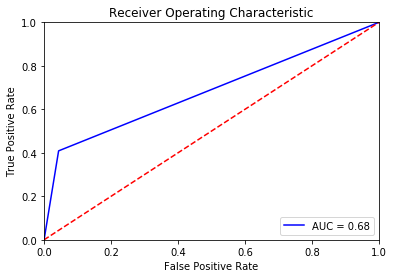

In [0]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(actual, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


##### 4.7 Model Optimization: Decision Tree Cross Validation

The reason why a validation set was not made is due to the fact that a cross validated model was actually implemented and tried. The cross validation would handle the job of a validation set, since it internally validates. Typically, the cross validation actually boosted the score of interest (F1-Score) by a good margin of 0.05 to 0.07. However, due to cluster constraints, this was not tried on the final feature set. Uncomment the code below to run the cross validated Decision Tree. 

Overview: Instantiate the DecisionTreeClassifier and create a Grid Builder. At most, two possible parameters to optimize on were ever passed to minimize the load on the cluster. However, due to a singular cluster shared across multiple teams, other people running neural networks impacted the time it took for the cross validation to run. The model evaluates based on the MultiClassClassificationEvaluator F1-Score metric. The cross validation was run on 5 folds. Parallelism was set to 2 to increase processing rate, but it was never tried above 2 to reduce the load on the cluster. Finally, similar to the models above, the classification report of the model was displayed to view the final f1-score. Note, without a couple of the highest performing features pulled from the feature importance function for the model, the cross validated model had an F1 score of 0.46.

In [0]:
# import random as rand

# # Attempt at automated hyperparameter tuning for Decision Tree model
# #Create ParamGrid for Cross Validation
# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")




# dtparamGrid = (ParamGridBuilder()
#              .addGrid(dt.maxDepth, [10,15])
#              .addGrid(dt.maxBins, [15,20])
#              .addGrid(dt.minInstancesPerNode, [5])
#              .build())

# # Evaluate model by optimizing on F1 Score
# dtevaluator = MulticlassClassificationEvaluator(metricName="f1")


# # Create 5-fold CrossValidator
# dtcv = CrossValidator(estimator = dt,
# estimatorParamMaps = dtparamGrid,
#                       evaluator = dtevaluator,
#                       numFolds = 5, parallelism = 2, collectSubModels=True)

# # Run cross validations
# #dtcvModel, folds  = dtcv.fit(df)
# dtcvModel = dtcv.fit(train)
# print(dtcvModel)

# # Use test set here so we can measure the accuracy of our model on new data
# dtpredictions = dtcvModel.transform(test)

# # Evaluate best model
# # Create an array of the prediction labels and the true labels
# preds_and_labels = dtpredictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')

# #Select only prediction and label columns
# preds_and_labels = preds_and_labels.select(['prediction','label'])
# #Create output vectors and true values to calculate metrics
# actual = np.array(preds_and_labels.select('label').collect())
# pred = np.array(preds_and_labels.select('prediction').collect())
# print(classification_report(actual, pred))

In [0]:
# #Save the model
# dtc_path = '10DecisionTreeCVFullSCALER'+ "/dtc"
# print(dtc_path)
# dtcvModel.save(dtc_path)

##### 4.8 Model Construction: Feature Importance with Decision Tree

From the feature importance of the model, visualize the top performing features for the decision tree to split on were all engineered features. Most importantly, the prior arrival and departure delay contribute the most in the model's delay prediction algorithm.

0
Out[93]:

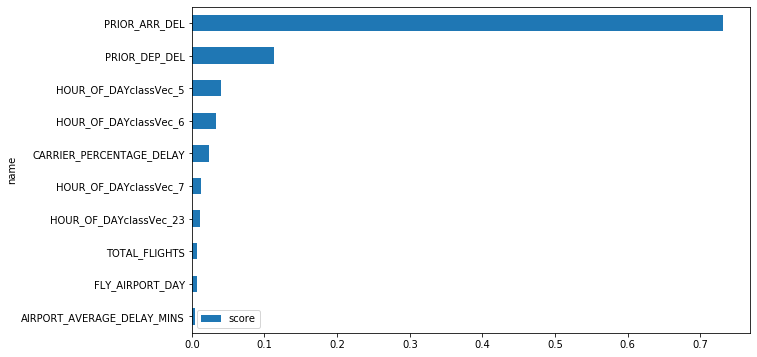

<matplotlib.axes._subplots.AxesSubplot at 0x7f838db82750>

In [0]:
importance = model.featureImportances
 
feature_names = train.schema["features"].metadata["ml_attr"]["attrs"]
dict_feature_names={}
for key in feature_names.keys():
  for i in range(len(feature_names[key])):
    dict_feature_names[feature_names[key][i]['idx']]= feature_names[key][i]['name']
#print(dict_feature_names)
featureNames = pd.DataFrame(list(dict_feature_names.items()),columns = ['index','name'])
featureNames# summarize feature importance


import matplotlib.pyplot as plt
imp = pd.DataFrame(importance.toArray())
 
for col in imp.columns: 
    print(col) 
imp.rename( columns={0:'score'}, inplace=True )

df1 = imp.sort_values('score',ascending = False).head(10)
df1= df1.reset_index()

df2=pd.merge(featureNames, df1, on='index')
df2=df2.sort_values('score', ascending=True)

df2.plot(x='name', y='score',kind="barh", figsize=(10,6))


##### 4.9 Model Selection: Random Forest

Random Forest, as an emsemble based approach which constructs, many instead of one Decision Tree on the data.  It employs bagging and randomizing feature selection to build a forest of trees.  Typically Random Forest outperforms a straight Decision Tree appoach, when Decision Trees is the underlying classification method.  However, that was not the result here with the chosen feature set and data provided.  This suggests that the data was highly consistent and correlated.  In other words the exploitation of randomization and majority vote inherent in the technique did not improve the information signals to the overall classification. Further explanations could be found in the fact that the weather data provided very low signal to the model and the airline features were highly correlated and categorical in nature, thus vectorized.  In addition resource constraints precluded hyperparameter tuning although it seems unlikely that such tuning would improve results appreciably given the observations presented here.  The model and the results are presented below.

In [0]:
# train our model using training data
rf = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees=30)

rf.setMaxDepth(10)\
 .setMaxBins(10)\
 .setMinInstancesPerNode(5)

model = rf.fit(train)

# test our model and make predictions using testing data
predictions = model.transform(test)
predictions.select("prediction", "label").show(5)

# # evaluate the performance of the classifier
# # evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
# evaluator = BinaryClassificationEvaluator()
# accuracy = evaluator.evaluate(predictions)
# print("Test Error = %g" % (1.0 - accuracy))
# print("Accuracy = %g " % accuracy)

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

#Create output vectors and true values to calculate metrics
actual = np.array(preds_and_labels.select('label').collect())
pred = np.array(preds_and_labels.select('prediction').collect())
print(classification_report(actual, pred))

+----------+-----+
prediction|label|
+----------+-----+
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
+----------+-----+
only showing top 5 rows

 precision recall f1-score support

 0.0 0.87 0.96 0.91 5575045
 1.0 0.70 0.39 0.50 1292474

 accuracy 0.85 6867519
 macro avg 0.78 0.68 0.71 6867519
weighted avg 0.84 0.85 0.84 6867519

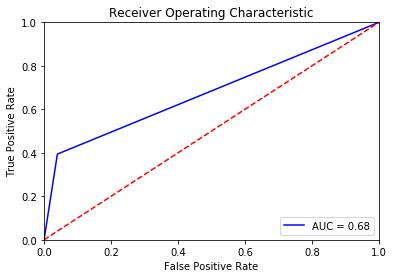

In [0]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(actual, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
# #Save the model
# dtc_path = '10PriorDelayNoStandard'+ "/rf"

# model.save(dtc_path)

#####  4.10 GBT Classifier

One of many boosting algorithms, GBT Classifier helps in dealing with the bias variance trade-off. Boosting is a sequential technique which works on the principle of ensemble learning. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighted based on the outcomes of previous instance at t-1. The outcomes predicted correctly are given a lower weight and the ones incorrectly classified are weighted higher.

The overall parameters of this ensemble model can be divided into three categories.  The first is Tree-Specific Parameters.  Examples of those include min_samples_split, min_samples_leaf, max_depth, max_leaf_nodes, max_features. The second is Boosting Parameters and these include learning_rate, n_estimators and subsample. Lastly there are several miscellaneous parameters including loss(loss function), init(initialization of the output), warm_start, and presort. Generally, the default value of 0.1 works reasonably well, but somewhere between 0.05 to 0.2 could produce improvements for different problems.  An objective is to determine the optimum number of trees for a given learning rate, usually range from 40 to 70 trees.  Tree-specific parameters are tuned the chosen learning rate and number of trees.  Typically, lowering the learning rate and increasing the estimators proportionally prouces more robust models.

Given time constraint and cluster resource issues, we were not able to fully explore various combinations of the hyper-parameters to achieve the best model performance.

In [0]:
gbt = GBTClassifier(labelCol="label", featuresCol="features",maxIter=10, subsamplingRate=0.8, maxDepth = 10, featureSubsetStrategy='sqrt',maxBins=32, minInstancesPerNode=1)
  
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
 
predictions.select("prediction", "label").show(5)

preds_and_labels = predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

#Create output vectors and true values to calculate metrics
actual = np.array(preds_and_labels.select('label').collect())
pred = np.array(preds_and_labels.select('prediction').collect())
print(classification_report(actual, pred))

+----------+-----+
prediction|label|
+----------+-----+
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
+----------+-----+
only showing top 5 rows

 precision recall f1-score support

 0.0 0.86 0.97 0.91 5575045
 1.0 0.71 0.34 0.46 1292474

 accuracy 0.85 6867519
 macro avg 0.79 0.65 0.69 6867519
weighted avg 0.84 0.85 0.83 6867519

0
Out[98]:

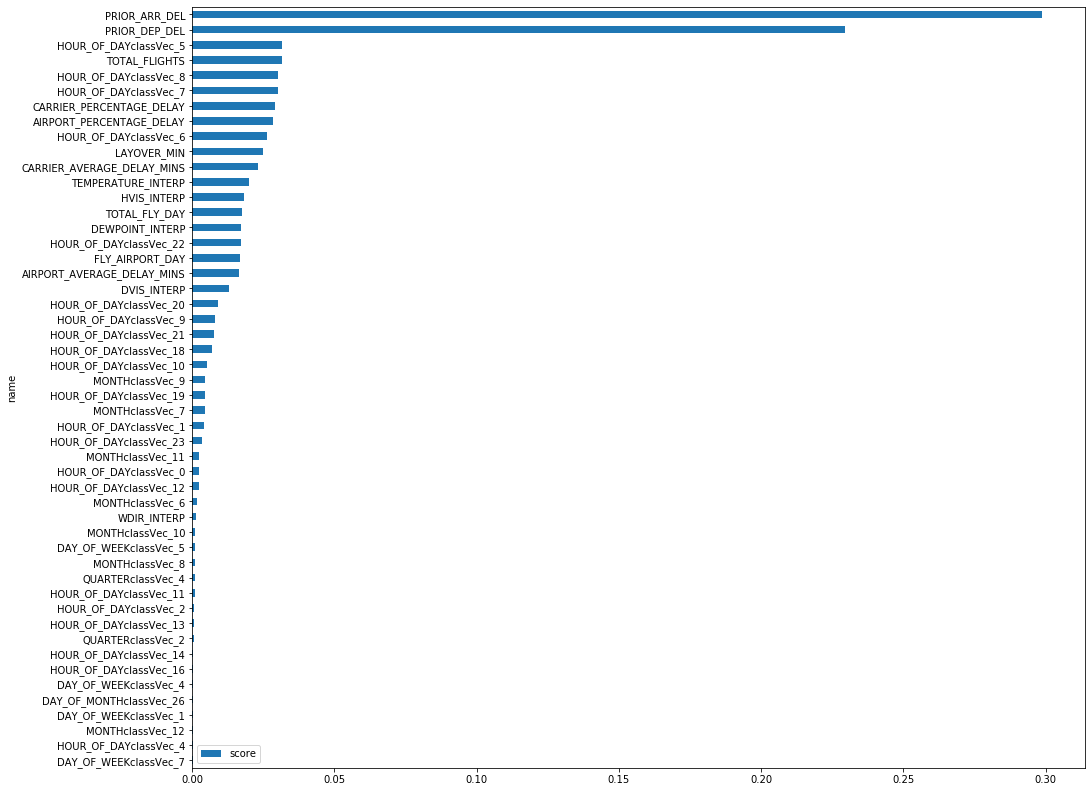

<matplotlib.axes._subplots.AxesSubplot at 0x7f8375520d90>

In [0]:
feature_names = train.schema["features"].metadata["ml_attr"]["attrs"]
dict_feature_names={}
for key in feature_names.keys():
  for i in range(len(feature_names[key])):
    dict_feature_names[feature_names[key][i]['idx']]= feature_names[key][i]['name']
#print(dict_feature_names)
featureNames = pd.DataFrame(list(dict_feature_names.items()),columns = ['index','name'])
featureNames

importance = gbtModel.featureImportances
    

imp = pd.DataFrame(importance.toArray())
 
for col in imp.columns: 
    print(col) 
imp.rename( columns={0:'score'}, inplace=True )

df1 = imp.sort_values('score',ascending = False).head(50)
df1= df1.reset_index()

df2=pd.merge(featureNames, df1, on='index')
df2=df2.sort_values('score', ascending=True)

df2.plot(x='name', y='score',kind="barh", figsize=(16,14))

### 5. Conclusions

The project looked at the binary classification of a given flight for prediction of a departure delay greater than fiften minutes from its schedule (CRS) departures time.  The project employed a history of flight data, here referred to as the Airline Flight Table, which spanned 370 airports and five years worth of flights.  The size of this dataset, over 38 million flights, required the use of scalable data and model pipline techniques.  Local surface weather data around the airports was incorporated in order to enhance delay prediction.  

Several classes of models were brought to bear on this problem, but ultimately tree-based modeling techniques produced the best results. Other models considered included several regression techniques.  The decision to employ tree-based methods was ultimately driven by a combination of the composition of the dataset and experimental results.  Surprisingly, ensemble techniques such as Gradient Boost and Random Forest did not produce appreciable improvements in the results, though resources constrained the investigation.

Leveraging domain knowledge to build new features played the most important role in improving prediction results. Engineered features that relied on logistic and temporal features boosted model performance substantially. For example, it is fairly intuitive to see that if the previous flight is delayed, it would affect the schedule of the currrent flight of interest with high probability. This is why it is important for airlines and carriers to have an optimized, but still flexible scheduling model to allow flights to recover from impredicted, logistic issues. Keeping that in mind, it was reassuring to see that the characteristic, features used to capture the fixed logistic effects causing delay, airport and airline average delay and percentage delay, had a ranked highly on the feature importance graph. Temporal features (i.e hour of day, month, quarter) performed fairly well. However, t was expected through the EDA and domain research that the time of day, day of the week, and time of the year have a correlation with delayed flights. From the feature importance vector, flights scheduled early in the morning (5-8 A.M.) and in the evening (8-10 P.M.) have some strong feature importance that the model picked up on when predicting delays. This makes sense, since most people will choose  to outside of the normal working hours - fly early in the morning or late in the evening. More people correlate to a higher probability of logistic issues, leading to a higher probability of delay. 

The inclusion of a surface weather table was a complicated undertaking that ultimately produced little or no gain in delay prediction even with fairly sophisticated interpolation efforts. As mentioned previously, the best models with engineered features performed essentially as well without surface weather data.  One explanation for this is the fact that surface weather rarely affects schedules.  Important exceptions are ice and de-icing planes and high winds (usually due to storms). Avionic weather data is typically gathered from avionic tuned radars that are pitched at much higher elevations out hundreds of miless such as the 159 NEXRAD systems that generates almost all the weather vewed by the public. The incorporation of this type of data could be a promising avenue of study. With respect to the Decision Tree model an investigation of the node splits and feature choices suggests that aside from the interpolated dew metrics and visibility, the other weather-related metrics did not seem to be even considered in the tree based models with reasonable constraints on tree size. From the standpoint of prediction, logsitical features are a much more promising direction as well as maintenance schedules.  

Although eleven engineered logistical features were employed in this model and several more were considered, the project did not by any means exhaust the list of possible features that would affect airline delay, many more can be envisioned. For example, had time permitted the incorporation of total and current capacity of the airport at any point in time could allow the predicition of potenital logostocal bottlenecks. Such data would enable the impact of the current throughput in a time window to be analyzed as a ratio not an absolute value as was employed here. Along with  creating new features, the current features could be enhanced. 

From a modeling standpoint improvements could potentially be made by incorporating memory with deepers models and techniques such as LSTM.  These appraoches appear to be promising and incorporate delay progation dimensions. Implementing the prediction via a RNN to take care of storing things in memory per iteration could be a promising approach. 

The feature engineering and models employed here produced very good results.  For reference the classfication report from the Decision Tree is provided again below.

                   precision    recall  f1-score   support

         0.0           0.87      0.96      0.91   5575045
         1.0           0.68      0.41      0.51   1292474

    accuracy                               0.85   6867519
    macro avg          0.78      0.68      0.71   6867519
    weighted avg       0.84      0.85      0.84   6867519
 
The weighted average F1 Score on the test set was .84.  The results above used both the airline and weather data.  The classification report for the best model using airline data alone is provided below.


                  precision    recall  f1-score   support
         0.0           0.88      0.96      0.91   5730565
         1.0           0.69      0.41      0.51   1312579
    
    accuracy                               0.86   7043144
    macro avg          0.78      0.68      0.71   7043144
    weighted avg       0.84      0.86      0.84   7043144

The model performances are indistinguishable from the perspective of these metrics on the current test set. The two confusion matrices are provided below.  However, the confusion matrices below suggests that if better prediction of the underpredicted class, delays, is the critical business case, including weather information can help a bit.

**Airline Table with Weather**

              Predicted    Predicted  
              No Delay      Delay
     __________________________________         
     Actual |  5,325,742     249,303
    No Delay|
            |
    Actual  |  762,848       529,626
    Delay   |


**Airline Table Alone**

              Predicted    Predicted  
              No Delay      Delay
     __________________________________         
     Actual |  5,561,781     168,784
    No Delay|
            |
    Actual  |  844,010      468,569
    Delay   |


Both sets of metrics suggest that the toughest challenge is to predict the class of delayed flights.  The models are underpredicting delays but still accurately predicting overall.  The confusion matrix also illustrates that while the total number of incorrect predictions is not improved by the weather data, but the number of correctly predicted delayed flights is improved by approximately 9%. The best model without weather data predicts the class of no delays better by approximately the same percentage. This may or may not solve the problem from the standpoint of the underlying business and operational problems. As mentioned previously there are large costs associated both with predicting a delay when it does not occur and not predicting a delay when it does occur.  The balance F1 score of .84 suggests that this approach will balance both objectives most of the time. When the baswe of comparison is that current state of the art, these models fall about .05 points short using the chosen metrics. As mentioned in the EDA notebook some such state of the art models employ deep learning and CNN approaches.  

Throughout the W261 course, the main focus has been scalability. The first scalable problem addressed was efficient coding itself in the queries and join logic. What happened was that joins were being incorporated within a loop. This caused a very high Big O Efficiency score. To address this, the joins were moved to occur prior to the for loop. The values needed for the join were precomputed and stored in a separate table, and then the join was called. This reduced the data pipeline processing time from 40 minutes to 20 minutes. Broadcast joins were used to again make the pipeline more efficient. Although the impact was lower than the loops handling. Pyspark native ML models were used in training and testing the models. Along with the baseline models of Decision Trees and Linear Regressions that were taught, more complex ensemble methods such as Random Forest and Gradient Boosted Trees were also used. 

Aside from scalable program, the model was designed with generalizability in mind. All the features that were used are completely anonymous, meaning nothing is dependent on a name or entity. For example, if a new airport were to come up, if the model were trained on carrier and airport names, it would not be able to generalize to new airports. Which is why the implemented model was trained on airport and carrier characteristic data to account for that relationship.